## Ensemble 1

In [1]:
# # 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
# !pip install transformers
# !pip install ipywidgets

# # matplotlib에 한글 폰트가 나오도록 설치
# !pip install koreanize-matplotlib

# # 기존 설치된 pytorch cpu 버전을 제거 후 cuda로 설치
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # GPU 메모리 초기화를 위한 도구
# !sudo apt-get update && sudo apt-get install psmisc

# # efficientnet 모델
# !pip install efficientnet-pytorch

In [2]:
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib 사용 시 한글 폰트가 나오도록
import koreanize_matplotlib
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

In [3]:
import random
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

### GPU 장비 설정

In [4]:
!nvidia-smi

Mon Aug 18 13:29:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:CA:00.0 Off |                   On |
| N/A   40C    P0              68W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [5]:
!fuser -v /dev/nvidia*

                     USER        PID ACCESS COMMAND
/dev/nvidia2:        root     kernel mount /dev/nvidia2
/dev/nvidiactl:      root     kernel mount /dev/nvidiactl
/dev/nvidia-uvm:     root     kernel mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root     kernel mount /dev/nvidia-uvm-tools


In [6]:
# 메모리 초기화를 위한 커널 종료
# !kill -9 584

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터 준비

In [8]:
!pwd

/home/elicer


In [9]:
!ls /mnt/elice/dataset

'제출용 데이터'		 'TS_도막 손상_도막떨어짐'   TS_양품_선수
'TS_도장 불량_부풀음'	 'TS_도장 불량_이물질포함'
'TS_도막 손상_스크래치'   TS_양품_외판


In [10]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품",
    "TS_양품_외판": "양품",
}

ROOT = Path("/mnt/elice/dataset")
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (224, 224) # 128, 224, 256, 384, 512, 640

In [11]:
X, y = [], []
for folder, label in tqdm(folder_to_label.items()):
    d = ROOT / folder
    for p in tqdm(d.rglob("*")):
        if p.suffix.lower() in IMG_EXTS:
#         im = Image.open(p).convert("L").resize(IMG_SIZE)
            im = Image.open(p).resize(IMG_SIZE)
#          arr = np.array(im, dtype=np.float32) / 255.0
            arr = np.array(im)
            X.append(arr)#.ravel()) # flatten 하지 않고 128, 128 행렬 형태로 저장
            y.append(label)

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### 타깃값 분포

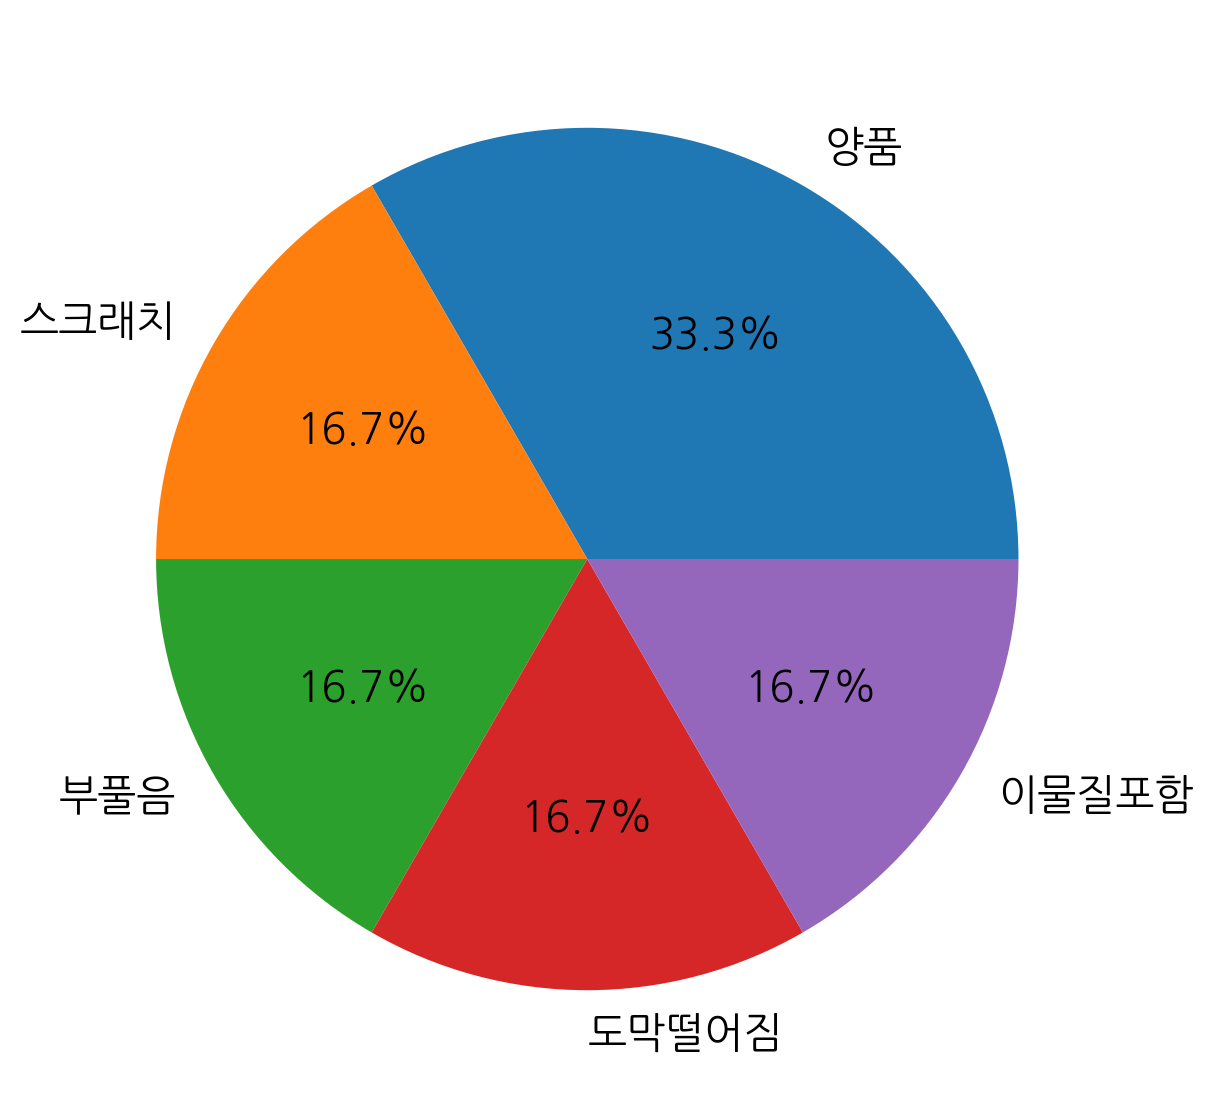

In [12]:
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# 타깃값 분포 파이 그래프
plt.pie(pd.Series(y).value_counts(), labels=pd.Series(y).value_counts().index, autopct='%.1f%%');

### 이미지 출력

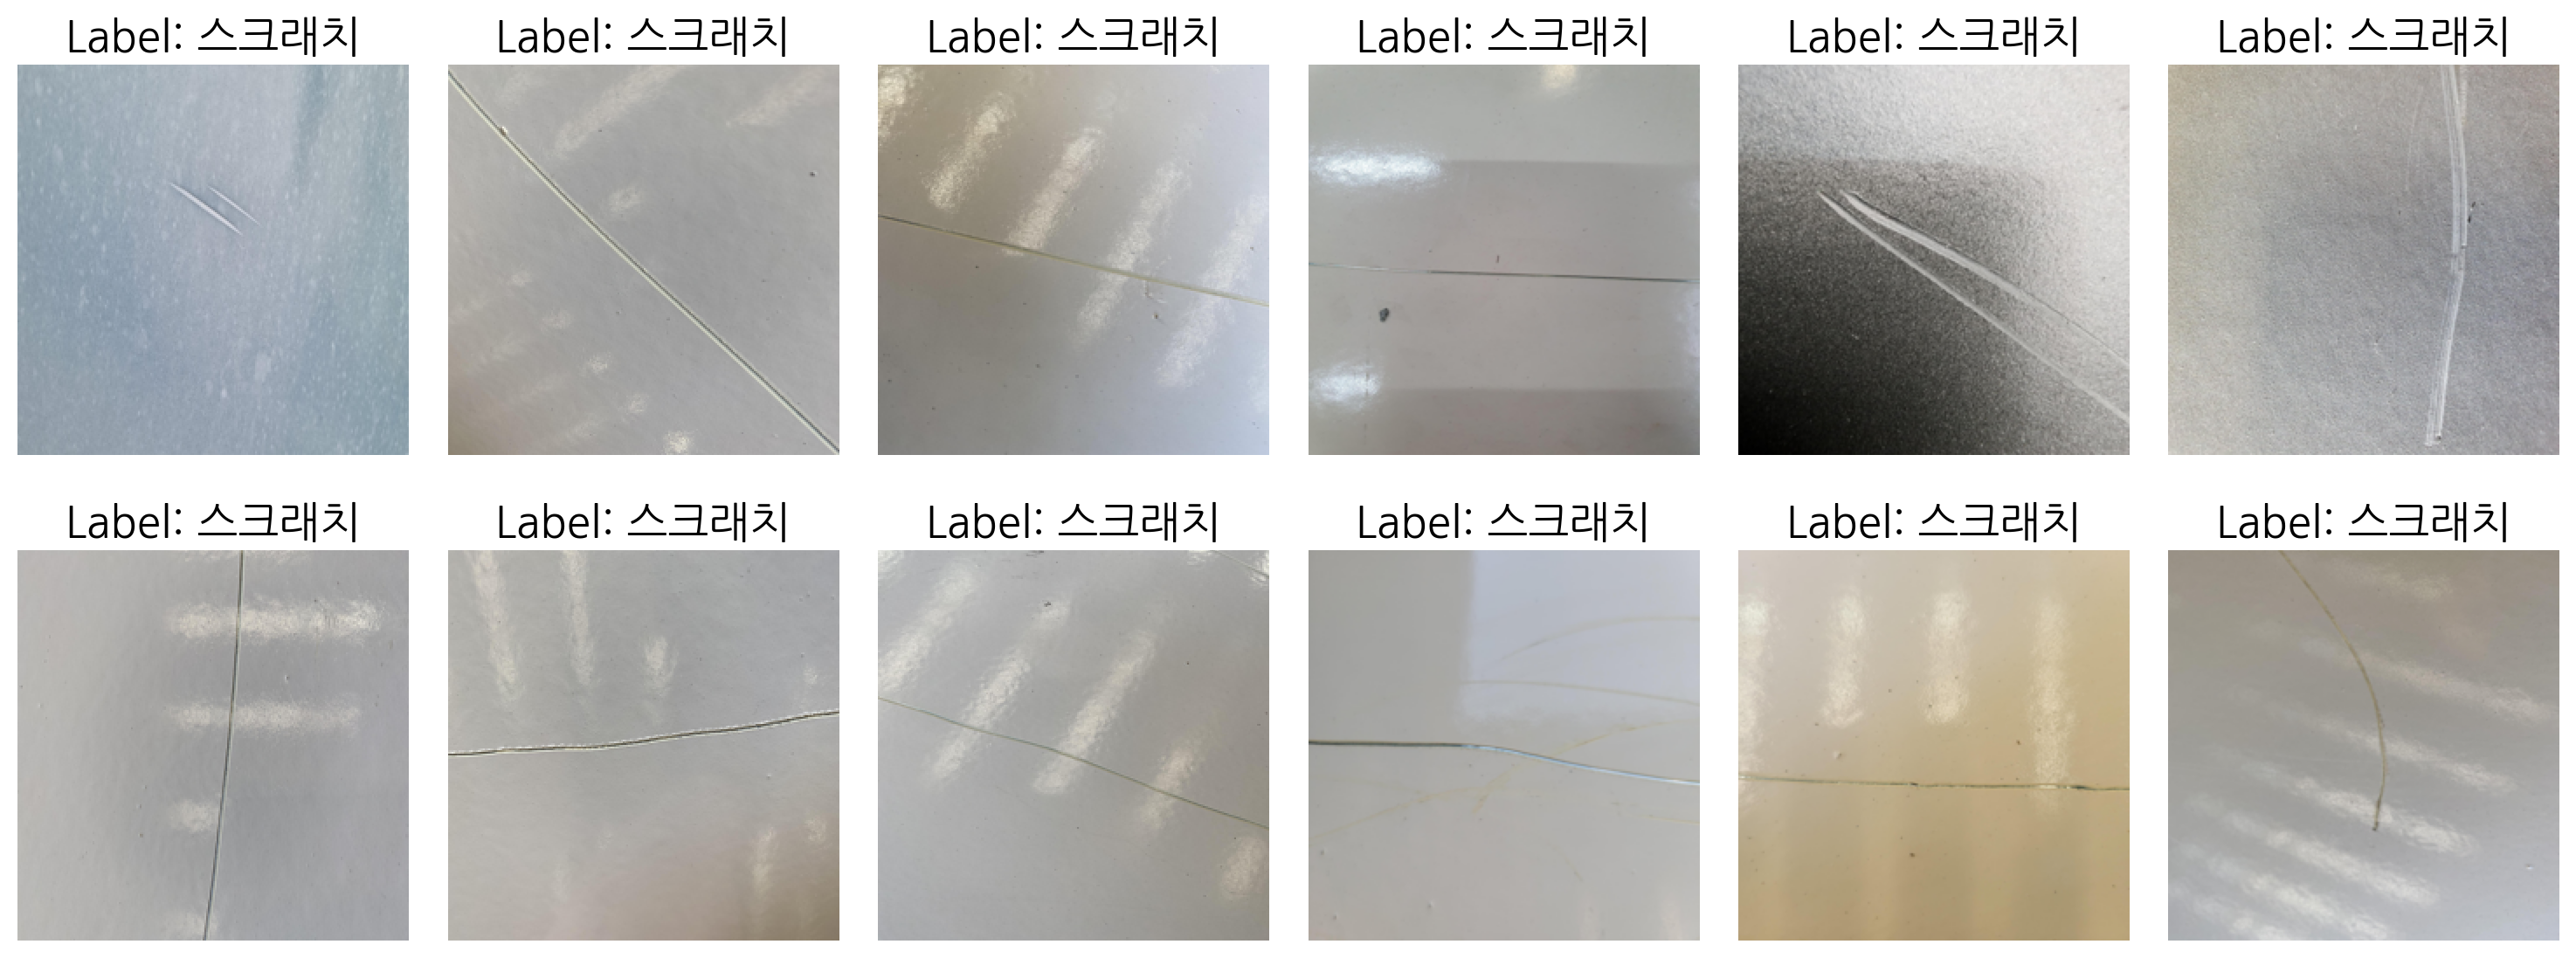

In [13]:
import matplotlib.gridspec as gridspec

# 이미지 및 라벨 확인
plt.rcParams['font.size'] = 15
plt.figure(figsize=(15, 6))  # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 2행 6열로 서브플롯 배치

# 12개의 이미지 출력 (X와 y의 길이가 12라고 가정)
for idx, (image_data, label) in enumerate(zip(X[:12], y[:12])):
    ax = plt.subplot(grid[idx])
    ax.imshow(image_data)
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # 축 정보 숨기기

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

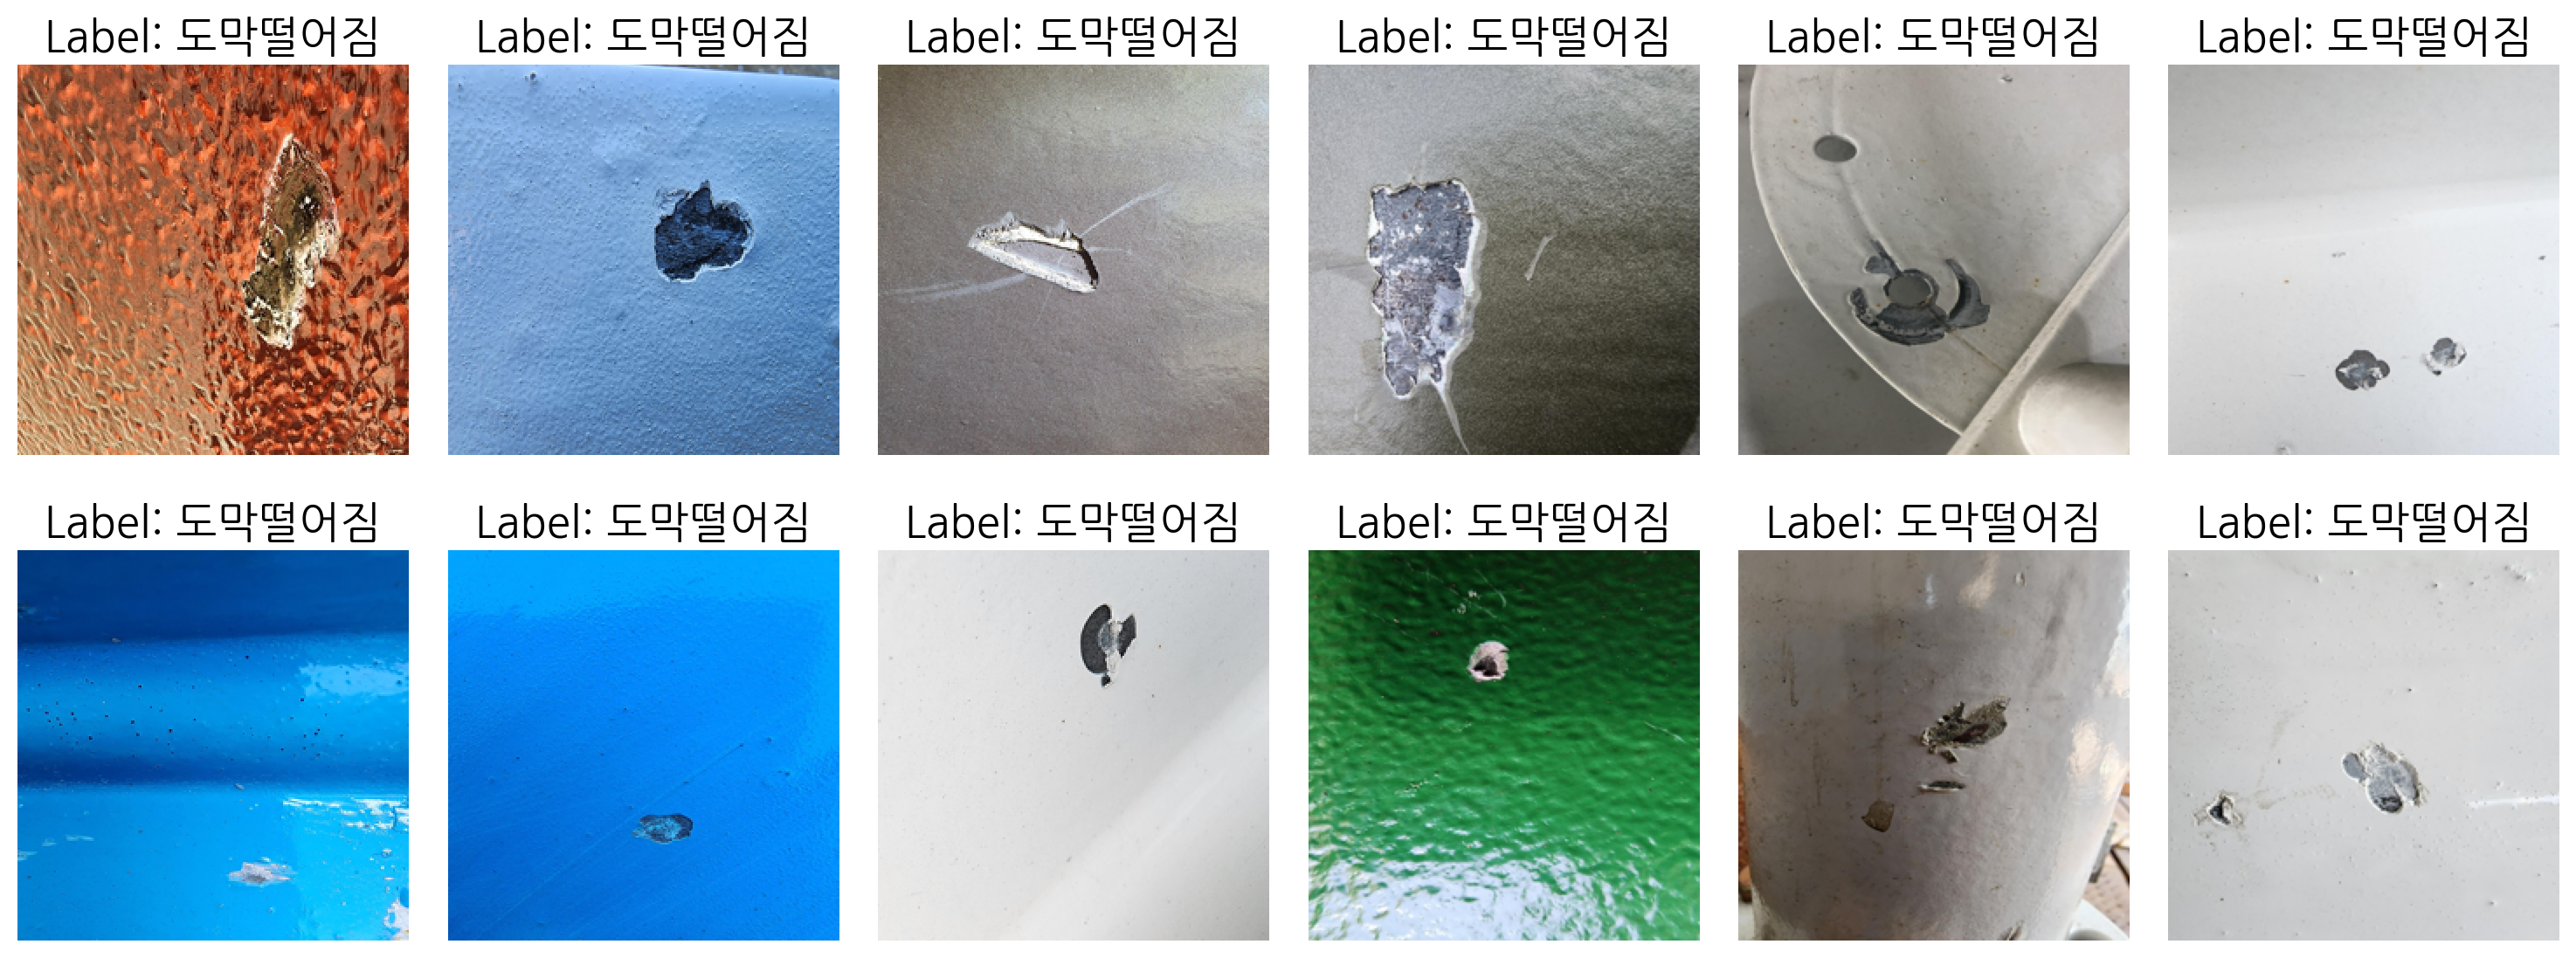

In [14]:
# 이미지 및 라벨 확인
plt.rcParams['font.size'] = 15
plt.figure(figsize=(15, 6))  # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 2행 6열로 서브플롯 배치

# 12개의 이미지 출력 (X와 y의 길이가 12라고 가정)
for idx, (image_data, label) in enumerate(zip(X[500:512], y[500:512])):
    ax = plt.subplot(grid[idx])
    ax.imshow(image_data)
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # 축 정보 숨기기

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

### 훈련 데이터, 검증 데이터 분리

In [15]:
# X는 (128, 128) 넘파이 배열들의 리스트, y는 라벨들의 리스트입니다.
# 훈련 데이터, 검증 데이터 분리

train_X, valid_X, train_y, valid_y = train_test_split(X, y,
                                                      test_size=0.15,
                                                      stratify=y,
                                                      random_state=50)

In [16]:
print('훈련 데이터 개수:', len(train_X))
print('검증 데이터 개수:', len(valid_X))

훈련 데이터 개수: 1020
검증 데이터 개수: 180


### 데이터셋 클래스 정의

In [17]:
# 파이토치 Dataset 클래스
class ImageDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        # 리스트에서 이미지와 라벨 가져오기
        image = self.X[idx]
        
        # numpy.ndarray 타입을 PIL Image로 변환 (오류 해결)
        # 이미지 데이터가 이미 RGB 형태(3차원)의 numpy 배열이라고 가정
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        # transform이 있다면 변환 적용
        if self.transform is not None:
            image = self.transform(image)
        
        if self.y is not None:
            label = self.y[idx]
            
            # PyTorch CNN 모델 학습을 위해 라벨을 숫자로 매핑 (예시)
            label_map = {'양품': 0, '스크래치': 1, '부풀음': 2, '도막떨어짐':3, '이물질포함':4}
            label_tensor = torch.tensor(label_map[label], dtype=torch.long)
            
            return image, label_tensor
        
        else:
            # 추론 과정에서 라벨이 없을 때 사용
            return image

### 이미지 변환기 정의 - Data Augmentation

In [18]:
# from torchvision import transforms # 이미지 변환을 위한 모듈

# # 훈련 데이터용 변환기
# transform_train = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Pad(IMG_SIZE[0], padding_mode='symmetric'), 
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomVerticalFlip(),
#                                       transforms.RandomRotation(30),
# #                                       transforms.Normalize(mean=[0.5], std=[0.5])
#                                       transforms.Normalize((0.485, 0.456, 0.406),
#                                                            (0.229, 0.224, 0.225))
#                                      ])

# # 검증 및 테스트 데이터용 변환기
# transform_test= transforms.Compose([transforms.ToTensor(),
#                                     transforms.Pad(IMG_SIZE[0], padding_mode='symmetric'),
# #                                     transforms.Normalize(mean=[0.5], std=[0.5])
#                                     transforms.Normalize((0.485, 0.456, 0.406),
#                                                            (0.229, 0.224, 0.225))
#                                    ])

In [19]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

### 데이터셋 및 데이터 로더 생성

In [20]:
# Dataset 객체 생성
dataset_train = ImageDataset(X=train_X, y=train_y, transform=transform_train)
dataset_valid = ImageDataset(X=valid_X, y=valid_y, transform=transform_test)

In [21]:
# 데이터로드 시 병렬 처리를 위한 시드 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [22]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 16

loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## 모델 생성

In [23]:
models_list =[] # 모델 저장용 리스트
history_list =[] # 모델 별 history 기록 저장용 리스트

In [24]:
from efficientnet_pytorch import EfficientNet

# 모델 생성
efficientnet_b1 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=5) 
efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=5)
efficientnet_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=5) 

# 장비 할당
efficientnet_b1 = efficientnet_b1.to(device)
efficientnet_b2 = efficientnet_b2.to(device)
efficientnet_b3 = efficientnet_b3.to(device)

# 리스트에 모델 저장
models_list.append(efficientnet_b1)
models_list.append(efficientnet_b2)
models_list.append(efficientnet_b3)

Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3


In [25]:
for idx, model in enumerate(models_list):
    num_parmas = sum(param.numel() for param in model.parameters())
    print(f'모델{idx+1} 파라미터 개수 : {num_parmas}')

모델1 파라미터 개수 : 6519589
모델2 파라미터 개수 : 7708039
모델3 파라미터 개수 : 10703917


### 손실 함수와 옵티마이저 설정

In [26]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [27]:
optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

## 모델 훈련

### 스케줄러 설정

In [28]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20 # 총 에폭

# 스케줄러
scheduler1 = get_cosine_schedule_with_warmup(optimizer1, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

scheduler2 = get_cosine_schedule_with_warmup(optimizer2, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

scheduler3 = get_cosine_schedule_with_warmup(optimizer3, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

### 모델 훈련

In [29]:
# # Validation Loss 기준 모델 학습
# def train(model, loader_train, loader_valid, criterion, optimizer, 
#           scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
#     valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

#     # 총 에폭만큼 반복
#     for epoch in range(epochs):
#         print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
#         # == [ 훈련 ] ==============================================
#         model.train()        # 모델을 훈련 상태로 설정
#         epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
#         # '반복 횟수'만큼 반복 
#         for images, labels in tqdm(loader_train):
#             # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
#             images = images.to(device)
#             labels = labels.to(device)
            
#             # 옵티마이저 내 기울기 초기화
#             optimizer.zero_grad()
#             # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
#             outputs = model(images)
#             # 손실 함수를 활용해 outputs와 labels의 손실값 계산
#             loss = criterion(outputs, labels)
#             # 현재 배치에서의 손실 추가 (훈련 데이터용)
#             epoch_train_loss += loss.item() 
#             loss.backward()       # 역전파 수행
#             optimizer.step()      # 가중치 갱신
#             if scheduler != None: # 스케줄러 학습률 갱신 
#                 scheduler.step() 

#         # 훈련 데이터 손실값 출력
#         print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
#         # == [ 검증 ] ==============================================
#         model.eval()         # 모델을 평가 상태로 설정 
#         epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
#         preds_list = []      # 예측값 저장용 리스트 초기화
#         true_list = []       # 실젯값 저장용 리스트 초기화
        
#         with torch.no_grad(): # 기울기 계산 비활성화
#             for images, labels in loader_valid:
#                 images = images.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 epoch_valid_loss += loss.item()
                
#                 # 예측값 및 실제값 
#                 preds = torch.argmax(outputs.cpu(), dim=1).numpy() 
#                 true = labels.cpu().numpy() 
    
#                 preds_list.extend(preds)
#                 true_list.extend(true)
                
#         # 정확도, 정밀도, 재현율, F1 점수 계산
#         val_accuracy = accuracy_score(true_list, preds_list)
#         val_precision = precision_score(true_list, preds_list, average='macro')
#         val_recall = recall_score(true_list, preds_list, average='macro')
#         val_f1_score = f1_score(true_list, preds_list, average='macro')

#         # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
#         print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
#         print(f'\t정확도 : {val_accuracy:.4f} / 정밀도 : {val_precision:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
#         # == [ 최적 모델 가중치 찾기 ] ==============================
#         # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
#         if epoch_valid_loss <= valid_loss_min: 
#             print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min/len(loader_valid):.4f} --> {epoch_valid_loss/len(loader_valid):.4f}). 모델 저장')
#             # 모델 가중치를 파일로 저장 
#             torch.save(model.state_dict(), save_file) 
#             valid_loss_min = epoch_valid_loss/len(loader_valid) # 최소 손실값 갱신 
#     return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [30]:
# ## Validation F1 Score 기준 모델 학습
# def train(model, loader_train, loader_valid, criterion, optimizer,
#           scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
#     valid_f1_score_max = 0.0

#     for epoch in range(epochs):
#         print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
#         # == [ 훈련 ] ==============================================
#         model.train()
#         epoch_train_loss = 0
#         train_preds_list = []
#         train_true_list = []
        
#         for images, labels in tqdm(loader_train):
#             images = images.to(device)
#             labels = labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             epoch_train_loss += loss.item()
#             loss.backward()
#             optimizer.step()
            
#             if scheduler != None:
#                 scheduler.step()

#             # 훈련 데이터 예측값 및 실제값
#             train_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
#             train_true = labels.cpu().numpy()
#             train_preds_list.extend(train_preds)
#             train_true_list.extend(train_true)

#         # 훈련 데이터 지표 계산 및 출력
#         train_accuracy = accuracy_score(train_true_list, train_preds_list)
#         train_precision = precision_score(train_true_list, train_preds_list, average='macro', zero_division=0)
#         train_recall = recall_score(train_true_list, train_preds_list, average='macro', zero_division=0)
#         train_f1_score = f1_score(train_true_list, train_preds_list, average='macro', zero_division=0)

#         print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
#         print(f'\t정확도 : {train_accuracy:.4f} / 정밀도 : {train_precision:.4f} / 재현율 : {train_recall:.4f} / F1 점수 : {train_f1_score:.4f}')

#         # == [ 검증 ] ==============================================
#         model.eval()
#         epoch_valid_loss = 0
#         valid_preds_list = []
#         valid_true_list = []
        
#         with torch.no_grad():
#             for images, labels in loader_valid:
#                 images = images.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 epoch_valid_loss += loss.item()
                
#                 valid_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
#                 valid_true = labels.cpu().numpy()
        
#                 valid_preds_list.extend(valid_preds)
#                 valid_true_list.extend(valid_true)
                
#         # 검증 데이터 지표 계산 및 출력
#         val_accuracy = accuracy_score(valid_true_list, valid_preds_list)
#         val_precision = precision_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
#         val_recall = recall_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
#         val_f1_score = f1_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)

#         print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
#         print(f'\t정확도 : {val_accuracy:.4f} / 정밀도 : {val_precision:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')

#         # == [ 최적 모델 가중치 찾기 ] ==============================
#         if val_f1_score >= valid_f1_score_max:
#             print(f'\t### 검증 F1 점수 증가 ({valid_f1_score_max:.4f} --> {val_f1_score:.4f}). 모델 저장')
#             torch.save(model.state_dict(), save_file)
#             valid_f1_score_max = val_f1_score

#     return torch.load(save_file)

In [31]:
## Validation F1 Score 기준 모델 학습 + history 기록
def train(model, loader_train, loader_valid, criterion, optimizer,
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_f1_score_max = 0.0
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1_score': [],
        'valid_loss': [], 'valid_accuracy': [], 'valid_precision': [], 'valid_recall': [], 'valid_f1_score': []
    }

    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()
        epoch_train_loss = 0
        train_preds_list = []
        train_true_list = []
        
        for images, labels in tqdm(loader_train):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if scheduler != None:
                scheduler.step()

            # 훈련 데이터 예측값 및 실제값
            train_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
            train_true = labels.cpu().numpy()
            train_preds_list.extend(train_preds)
            train_true_list.extend(train_true)

        # 훈련 데이터 지표 계산 및 출력
        train_loss = epoch_train_loss / len(loader_train)
        train_accuracy = accuracy_score(train_true_list, train_preds_list)
        train_precision = precision_score(train_true_list, train_preds_list, average='macro', zero_division=0)
        train_recall = recall_score(train_true_list, train_preds_list, average='macro', zero_division=0)
        train_f1_score = f1_score(train_true_list, train_preds_list, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1_score'].append(train_f1_score)

        print(f'\t훈련 데이터 손실값 : {train_loss:.4f}')
        print(f'\t정확도 : {train_accuracy:.4f} / 정밀도 : {train_precision:.4f} / 재현율 : {train_recall:.4f} / F1 점수 : {train_f1_score:.4f}')

        # == [ 검증 ] ==============================================
        model.eval()
        epoch_valid_loss = 0
        valid_preds_list = []
        valid_true_list = []
        
        with torch.no_grad():
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                valid_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
                valid_true = labels.cpu().numpy()
        
                valid_preds_list.extend(valid_preds)
                valid_true_list.extend(valid_true)
                
        # 검증 데이터 지표 계산 및 출력
        valid_loss = epoch_valid_loss / len(loader_valid)
        val_accuracy = accuracy_score(valid_true_list, valid_preds_list)
        val_precision = precision_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
        val_recall = recall_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
        val_f1_score = f1_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)

        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(val_accuracy)
        history['valid_precision'].append(val_precision)
        history['valid_recall'].append(val_recall)
        history['valid_f1_score'].append(val_f1_score)

        print(f'\t검증 데이터 손실값 : {valid_loss:.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 정밀도 : {val_precision:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')

        # == [ 최적 모델 가중치 찾기 ] ==============================
        if val_f1_score >= valid_f1_score_max:
            print(f'\t### 검증 F1 점수 증가 ({valid_f1_score_max:.4f} --> {val_f1_score:.4f}). 모델 저장')
            torch.save(model.state_dict(), save_file)
            valid_f1_score_max = val_f1_score

    # 모델 가중치와 훈련 이력을 반환
    return torch.load(save_file), history

In [32]:
def plot_training_metrics(history, epochs):
    """
    훈련 및 검증 지표를 시각화하는 함수입니다.

    Args:
        history (dict): 훈련 이력 데이터가 담긴 딕셔너리.
                        'train_loss', 'valid_loss' 등의 키를 포함해야 합니다.
        epochs (int): 총 훈련 에폭 수.
    """

    epochs_range = range(1, epochs + 1)
    
    # 모든 지표를 딕셔너리로 관리하여 반복문으로 처리
    metrics = {
        'loss': ('Training and Validation Loss', 'Loss'),
        'f1_score': ('Training and Validation F1 Score', 'F1 Score'),
        'accuracy': ('Training and Validation Accuracy', 'Accuracy'),
        'precision': ('Training and Validation Precision', 'Precision'),
        'recall': ('Training and Validation Recall', 'Recall')
    }

    # 각 지표에 대해 반복하여 그래프 생성
    for metric_key, (title, ylabel) in metrics.items():
        plt.figure(figsize=(10, 6))
        
        # 훈련 및 검증 데이터 플로팅
        plt.plot(epochs_range, history[f'train_{metric_key}'], label=f'Training {ylabel}')
        plt.plot(epochs_range, history[f'valid_{metric_key}'], label=f'Validation {ylabel}')
        
        # 그래프 제목 및 레이블 설정
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.legend()
        
        # Jupyter Notebook에서 그래프 표시
        plt.show()

In [33]:
def evaluate_and_plot(model, loader_valid, device, class_names):
    """
    Validation 데이터셋에 대한 Confusion Matrix 및 Classification Report를 생성하고 시각화합니다.
    
    Args:
        model (torch.nn.Module): 훈련된 모델
        loader_valid (torch.utils.data.DataLoader): 검증 데이터 로더
        device (str): 모델이 위치한 장치 ('cpu' 또는 'cuda')
        class_names (list): 클래스 이름 목록 (예: ['cat', 'dog', 'bird'])
    """
    
    # 모델을 평가 모드로 전환
    model.eval()
    
    true_labels = []
    predictions = []
    
    # 그라디언트 계산 비활성화
    with torch.no_grad():
        for images, labels in loader_valid:
            images = images.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    
    # == [ Confusion Matrix 시각화 ] =============================
    # Confusion Matrix 계산
    cm = confusion_matrix(true_labels, predictions)
    
    # Confusion Matrix 시각화
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    
    ax.set_title('Confusion Matrix on Validation Data')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    # 그래프를 화면에 표시
    plt.show()

    # == [ Classification Report 출력 ] ===========================
    # 각 클래스별 정밀도, 재현율, F1 점수를 포함하는 보고서 출력
    print("-------------------- Classification Report --------------------")
    print(classification_report(true_labels, predictions, target_names=class_names, zero_division=0))
    print("---------------------------------------------------------------")
    
    
# 클래스 이름을 정의 (실제 데이터셋의 클래스에 맞게 수정 필요)
class_names_list = ['양품', '스크래치', '부풀음', '도막떨어짐', '이물질포함']

In [34]:
# 첫 번째 모델 훈련
model_state_dict, history = train(model=models_list[0],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)

history_list.append(history)

# 첫 번째 모델에 최적 가중치 적용
models_list[0].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 1.1798
	정확도 : 0.6363 / 정밀도 : 0.6306 / 재현율 : 0.6229 / F1 점수 : 0.6168
	검증 데이터 손실값 : 0.5249
	정확도 : 0.9167 / 정밀도 : 0.9349 / 재현율 : 0.9000 / F1 점수 : 0.9126
	### 검증 F1 점수 증가 (0.0000 --> 0.9126). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2515
	정확도 : 0.9461 / 정밀도 : 0.9448 / 재현율 : 0.9406 / F1 점수 : 0.9426
	검증 데이터 손실값 : 0.0664
	정확도 : 0.9889 / 정밀도 : 0.9875 / 재현율 : 0.9867 / F1 점수 : 0.9867
	### 검증 F1 점수 증가 (0.9126 --> 0.9867). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1265
	정확도 : 0.9618 / 정밀도 : 0.9606 / 재현율 : 0.9594 / F1 점수 : 0.9600
	검증 데이터 손실값 : 0.0907
	정확도 : 0.9889 / 정밀도 : 0.9867 / 재현율 : 0.9867 / F1 점수 : 0.9867
	### 검증 F1 점수 증가 (0.9867 --> 0.9867). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0944
	정확도 : 0.9676 / 정밀도 : 0.9642 / 재현율 : 0.9647 / F1 점수 : 0.9644
	검증 데이터 손실값 : 0.1058
	정확도 : 0.9889 / 정밀도 : 0.9875 / 재현율 : 0.9867 / F1 점수 : 0.9867
에폭 [5/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0879
	정확도 : 0.9735 / 정밀도 : 0.9699 / 재현율 : 0.9700 / F1 점수 : 0.9700
	검증 데이터 손실값 : 0.3361
	정확도 : 0.9222 / 정밀도 : 0.9168 / 재현율 : 0.9100 / F1 점수 : 0.9095
에폭 [6/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0822
	정확도 : 0.9794 / 정밀도 : 0.9784 / 재현율 : 0.9776 / F1 점수 : 0.9779
	검증 데이터 손실값 : 0.1754
	정확도 : 0.9389 / 정밀도 : 0.9360 / 재현율 : 0.9367 / F1 점수 : 0.9335
에폭 [7/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0733
	정확도 : 0.9804 / 정밀도 : 0.9778 / 재현율 : 0.9794 / F1 점수 : 0.9786
	검증 데이터 손실값 : 0.1274
	정확도 : 0.9722 / 정밀도 : 0.9669 / 재현율 : 0.9667 / F1 점수 : 0.9667
에폭 [8/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0155
	정확도 : 0.9971 / 정밀도 : 0.9965 / 재현율 : 0.9965 / F1 점수 : 0.9965
	검증 데이터 손실값 : 0.1228
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [9/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0166
	정확도 : 0.9931 / 정밀도 : 0.9935 / 재현율 : 0.9918 / F1 점수 : 0.9926
	검증 데이터 손실값 : 0.0952
	정확도 : 0.9778 / 정밀도 : 0.9733 / 재현율 : 0.9733 / F1 점수 : 0.9733
에폭 [10/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0348
	정확도 : 0.9902 / 정밀도 : 0.9894 / 재현율 : 0.9888 / F1 점수 : 0.9891
	검증 데이터 손실값 : 0.0616
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [11/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0124
	정확도 : 0.9961 / 정밀도 : 0.9959 / 재현율 : 0.9959 / F1 점수 : 0.9959
	검증 데이터 손실값 : 0.1094
	정확도 : 0.9778 / 정밀도 : 0.9741 / 재현율 : 0.9733 / F1 점수 : 0.9733
에폭 [12/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0076
	정확도 : 0.9980 / 정밀도 : 0.9976 / 재현율 : 0.9976 / F1 점수 : 0.9976
	검증 데이터 손실값 : 0.0564
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [13/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0107
	정확도 : 0.9980 / 정밀도 : 0.9977 / 재현율 : 0.9976 / F1 점수 : 0.9976
	검증 데이터 손실값 : 0.0479
	정확도 : 0.9889 / 정밀도 : 0.9875 / 재현율 : 0.9867 / F1 점수 : 0.9867
에폭 [14/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0102
	정확도 : 0.9980 / 정밀도 : 0.9977 / 재현율 : 0.9982 / F1 점수 : 0.9979
	검증 데이터 손실값 : 0.0429
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [15/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0074
	정확도 : 0.9971 / 정밀도 : 0.9965 / 재현율 : 0.9965 / F1 점수 : 0.9965
	검증 데이터 손실값 : 0.0409
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [16/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0054
	정확도 : 0.9980 / 정밀도 : 0.9982 / 재현율 : 0.9976 / F1 점수 : 0.9979
	검증 데이터 손실값 : 0.0442
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [17/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0083
	정확도 : 0.9980 / 정밀도 : 0.9977 / 재현율 : 0.9982 / F1 점수 : 0.9979
	검증 데이터 손실값 : 0.0504
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [18/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0036
	정확도 : 0.9990 / 정밀도 : 0.9988 / 재현율 : 0.9988 / F1 점수 : 0.9988
	검증 데이터 손실값 : 0.0496
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [19/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0016
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0471
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [20/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0048
	정확도 : 0.9990 / 정밀도 : 0.9988 / 재현율 : 0.9988 / F1 점수 : 0.9988
	검증 데이터 손실값 : 0.0485
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800


<All keys matched successfully>

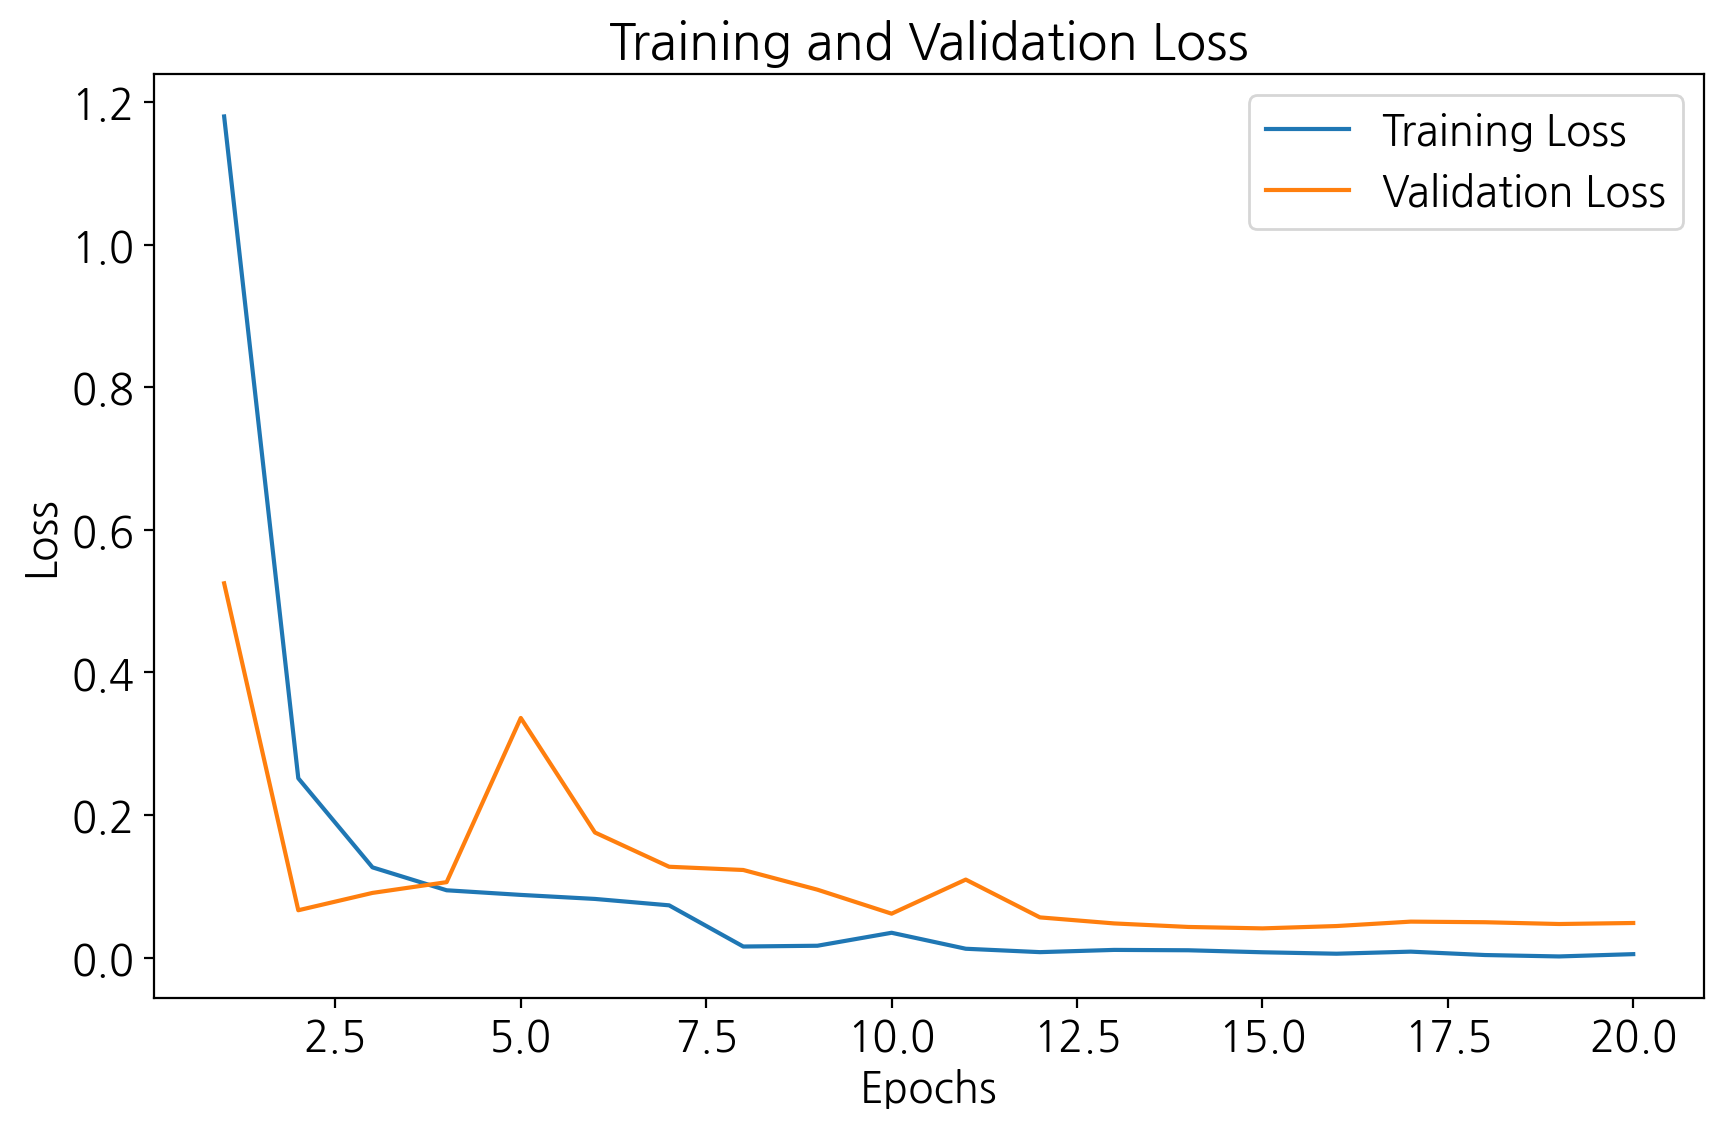

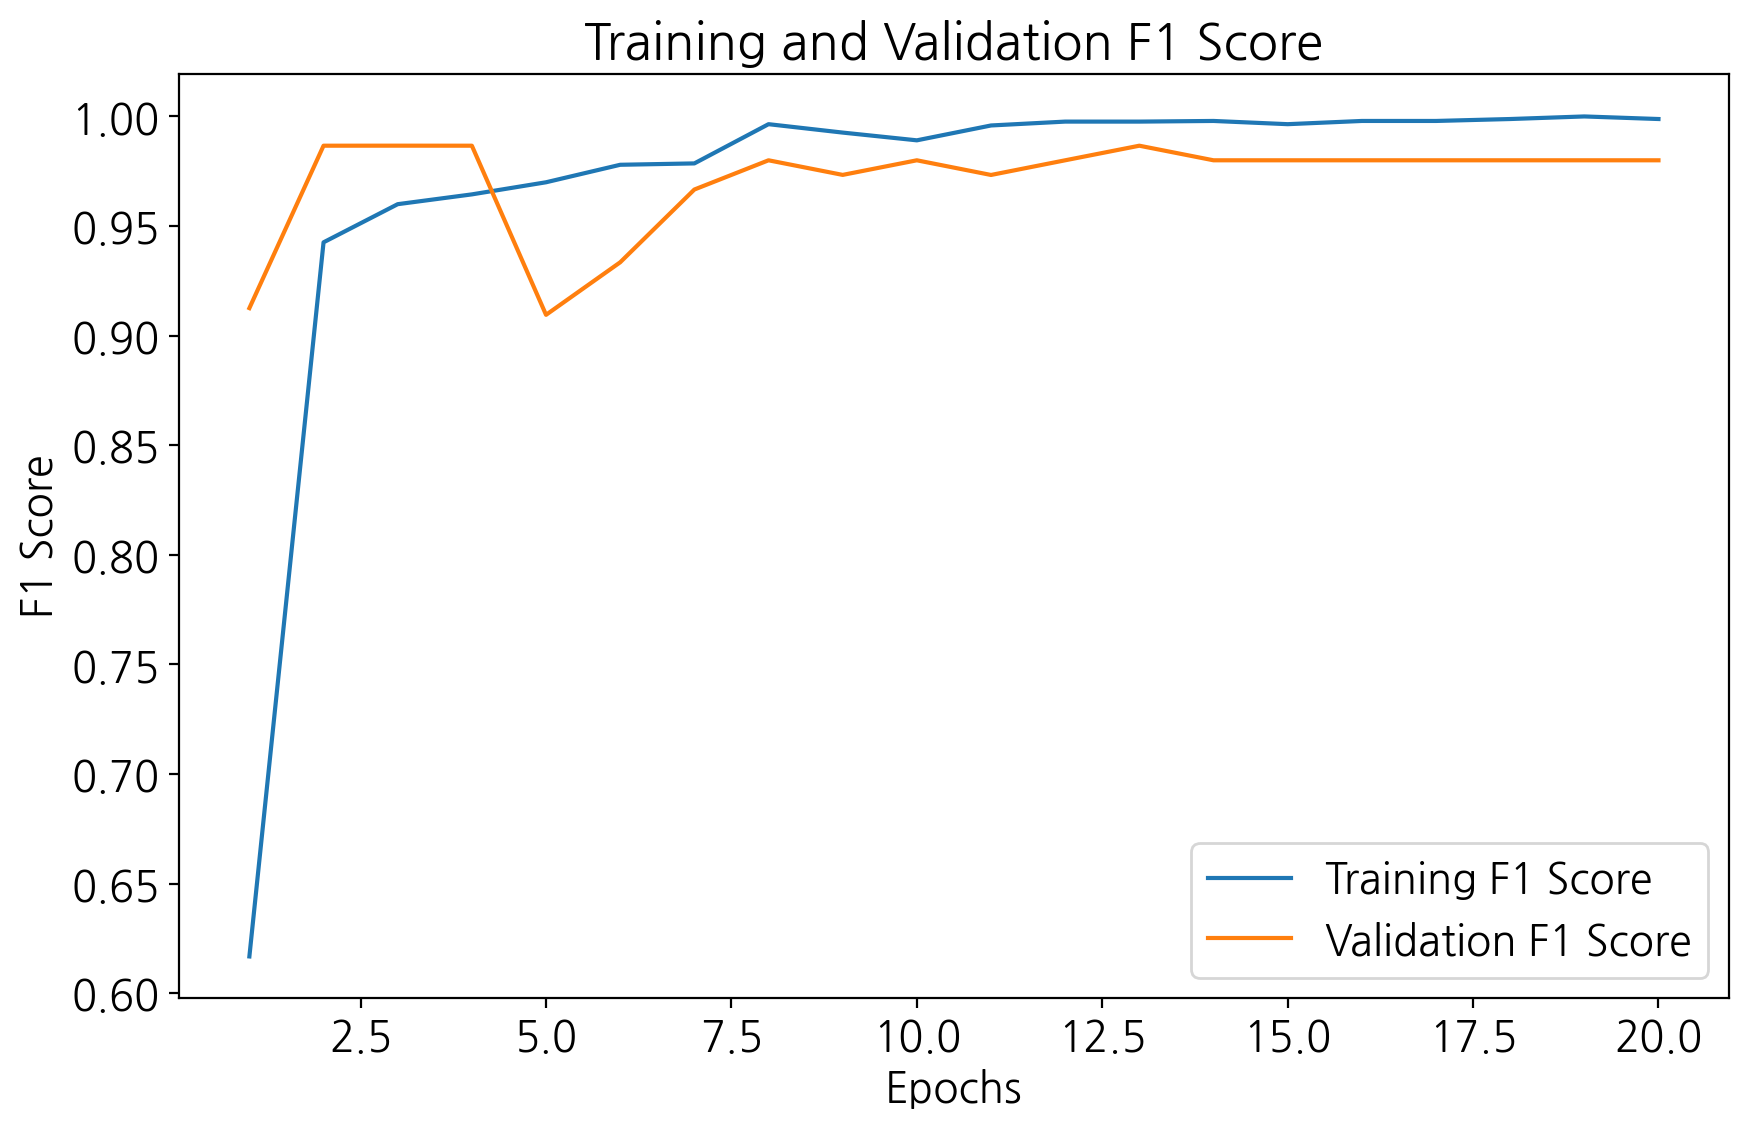

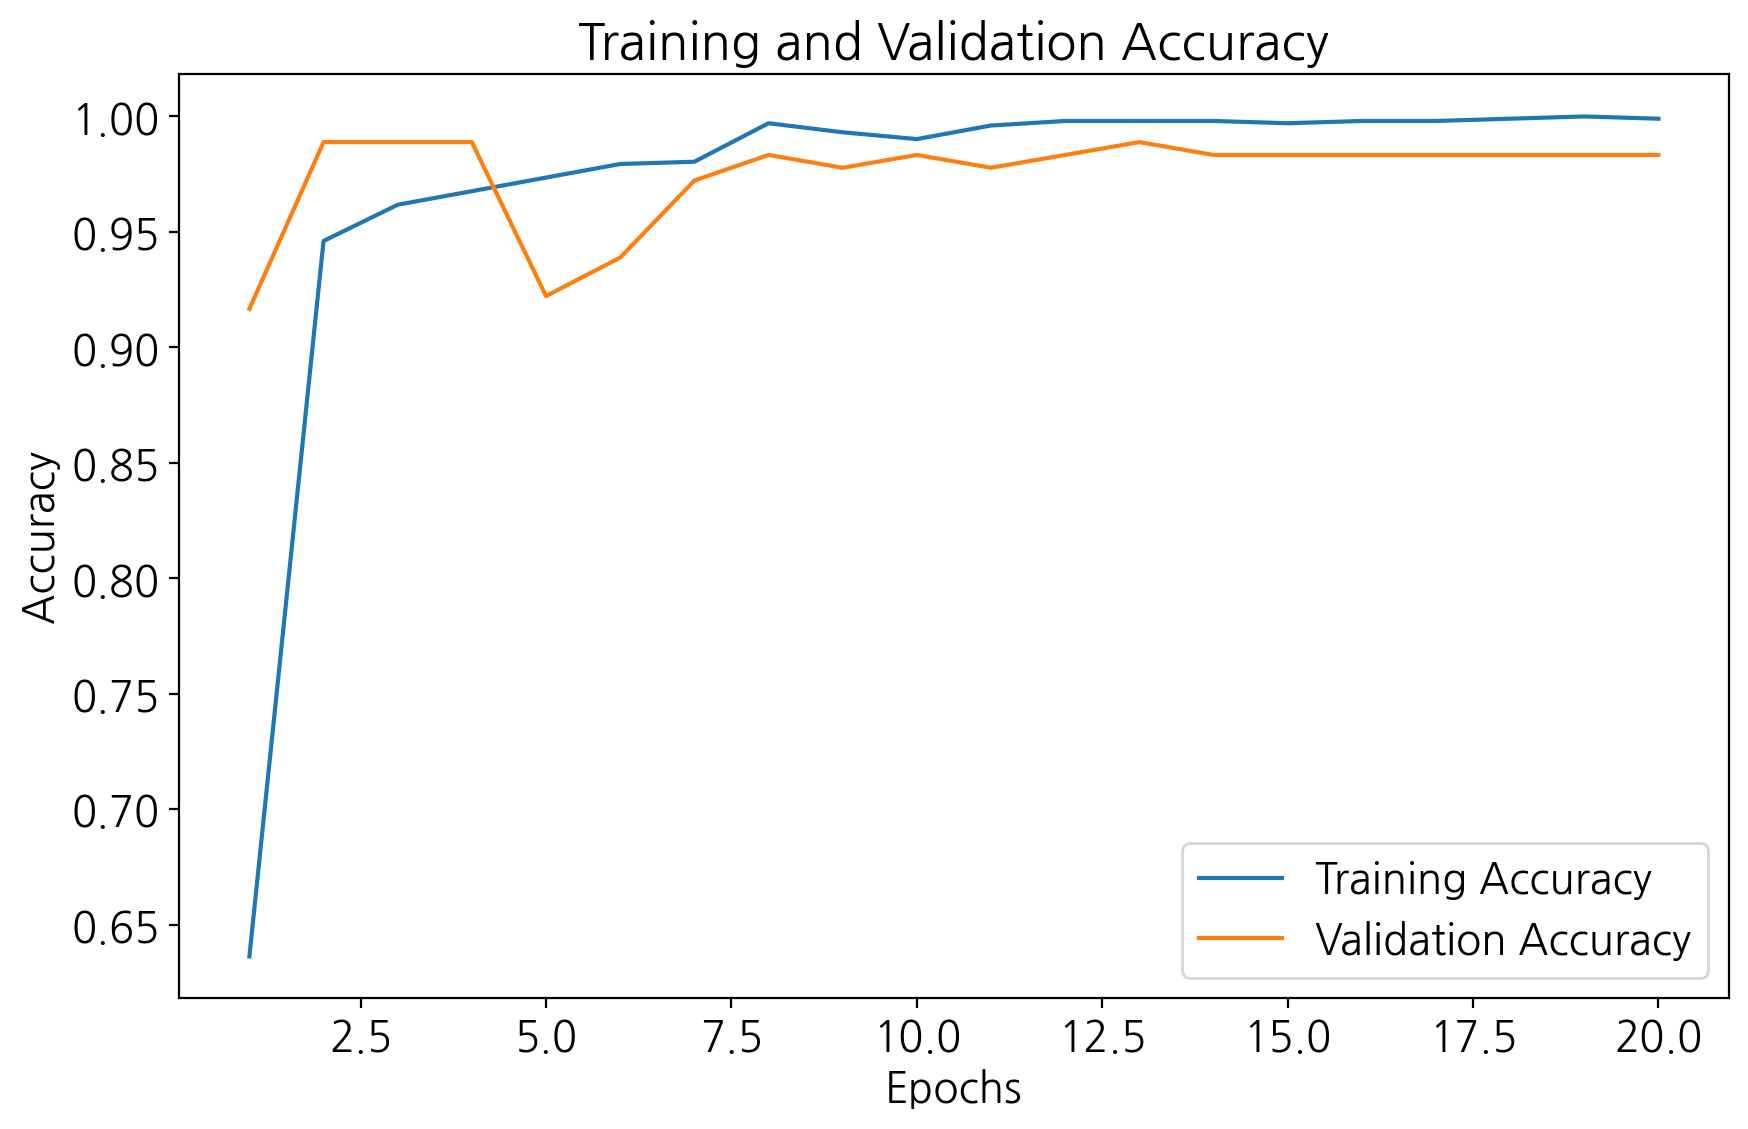

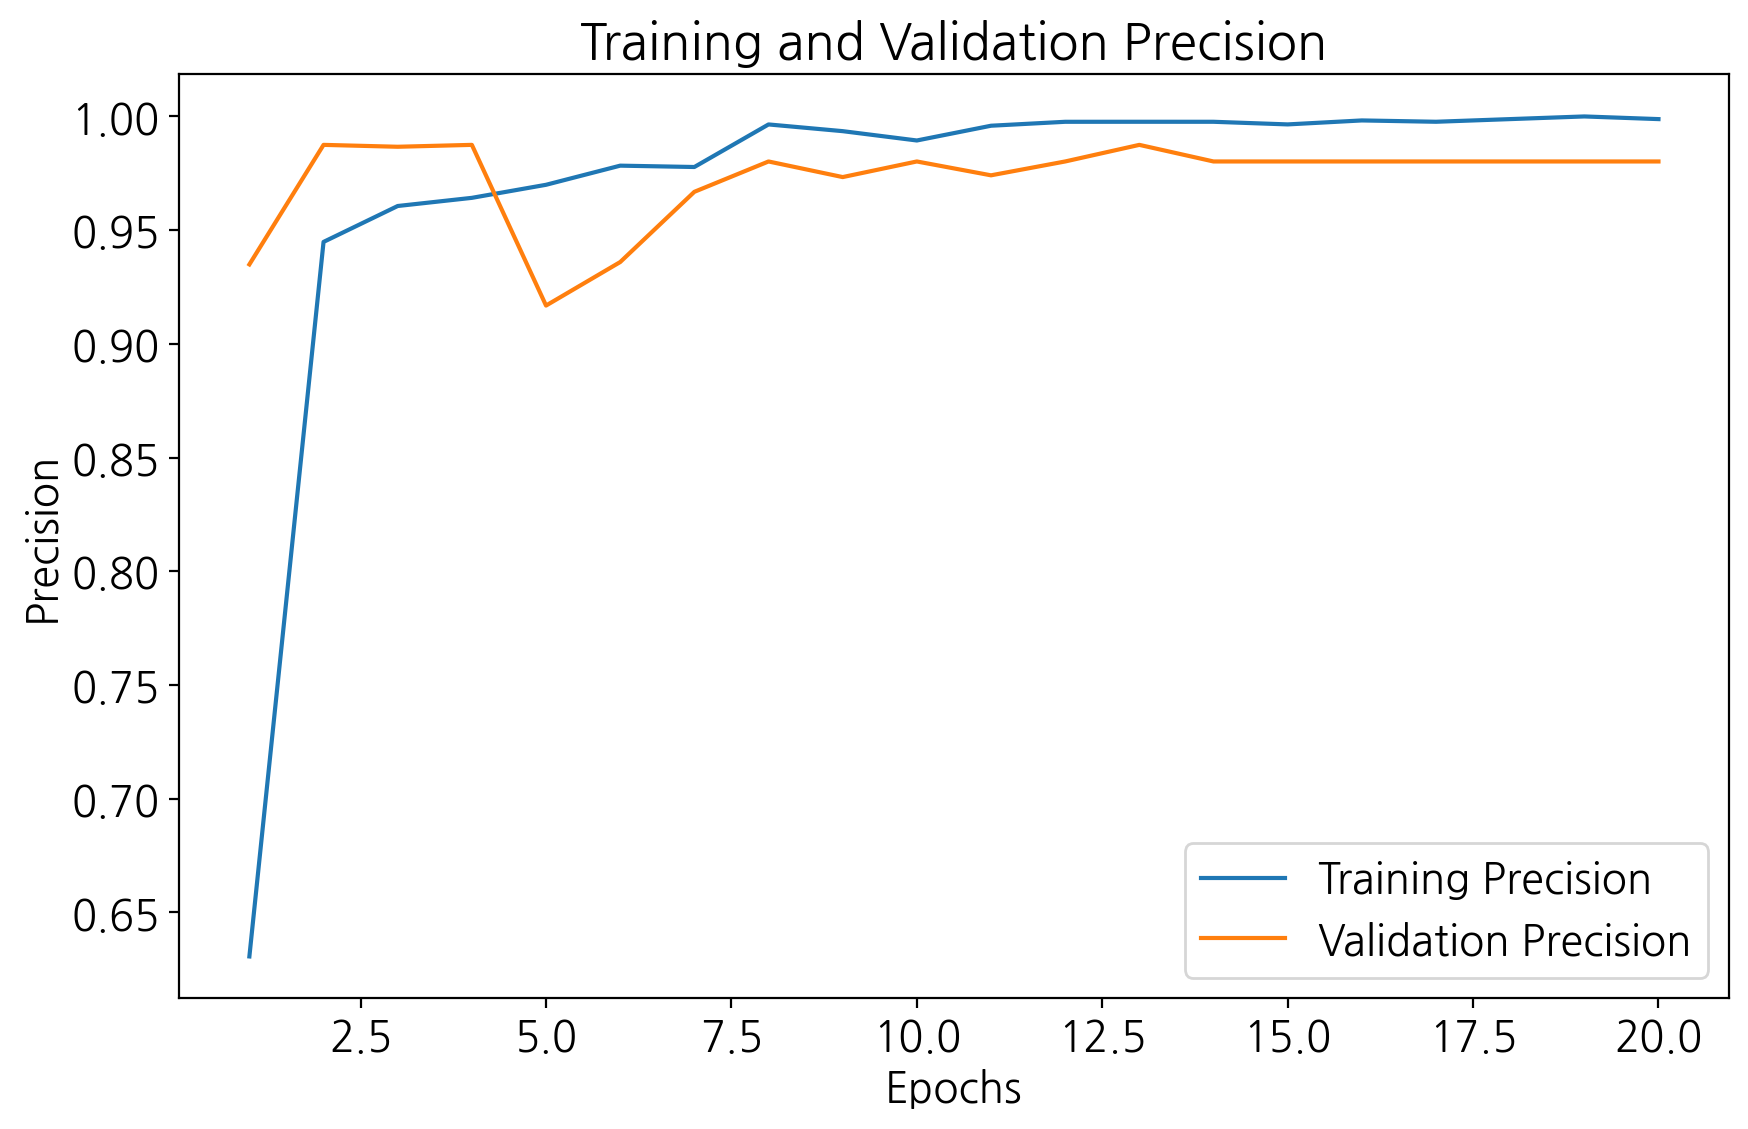

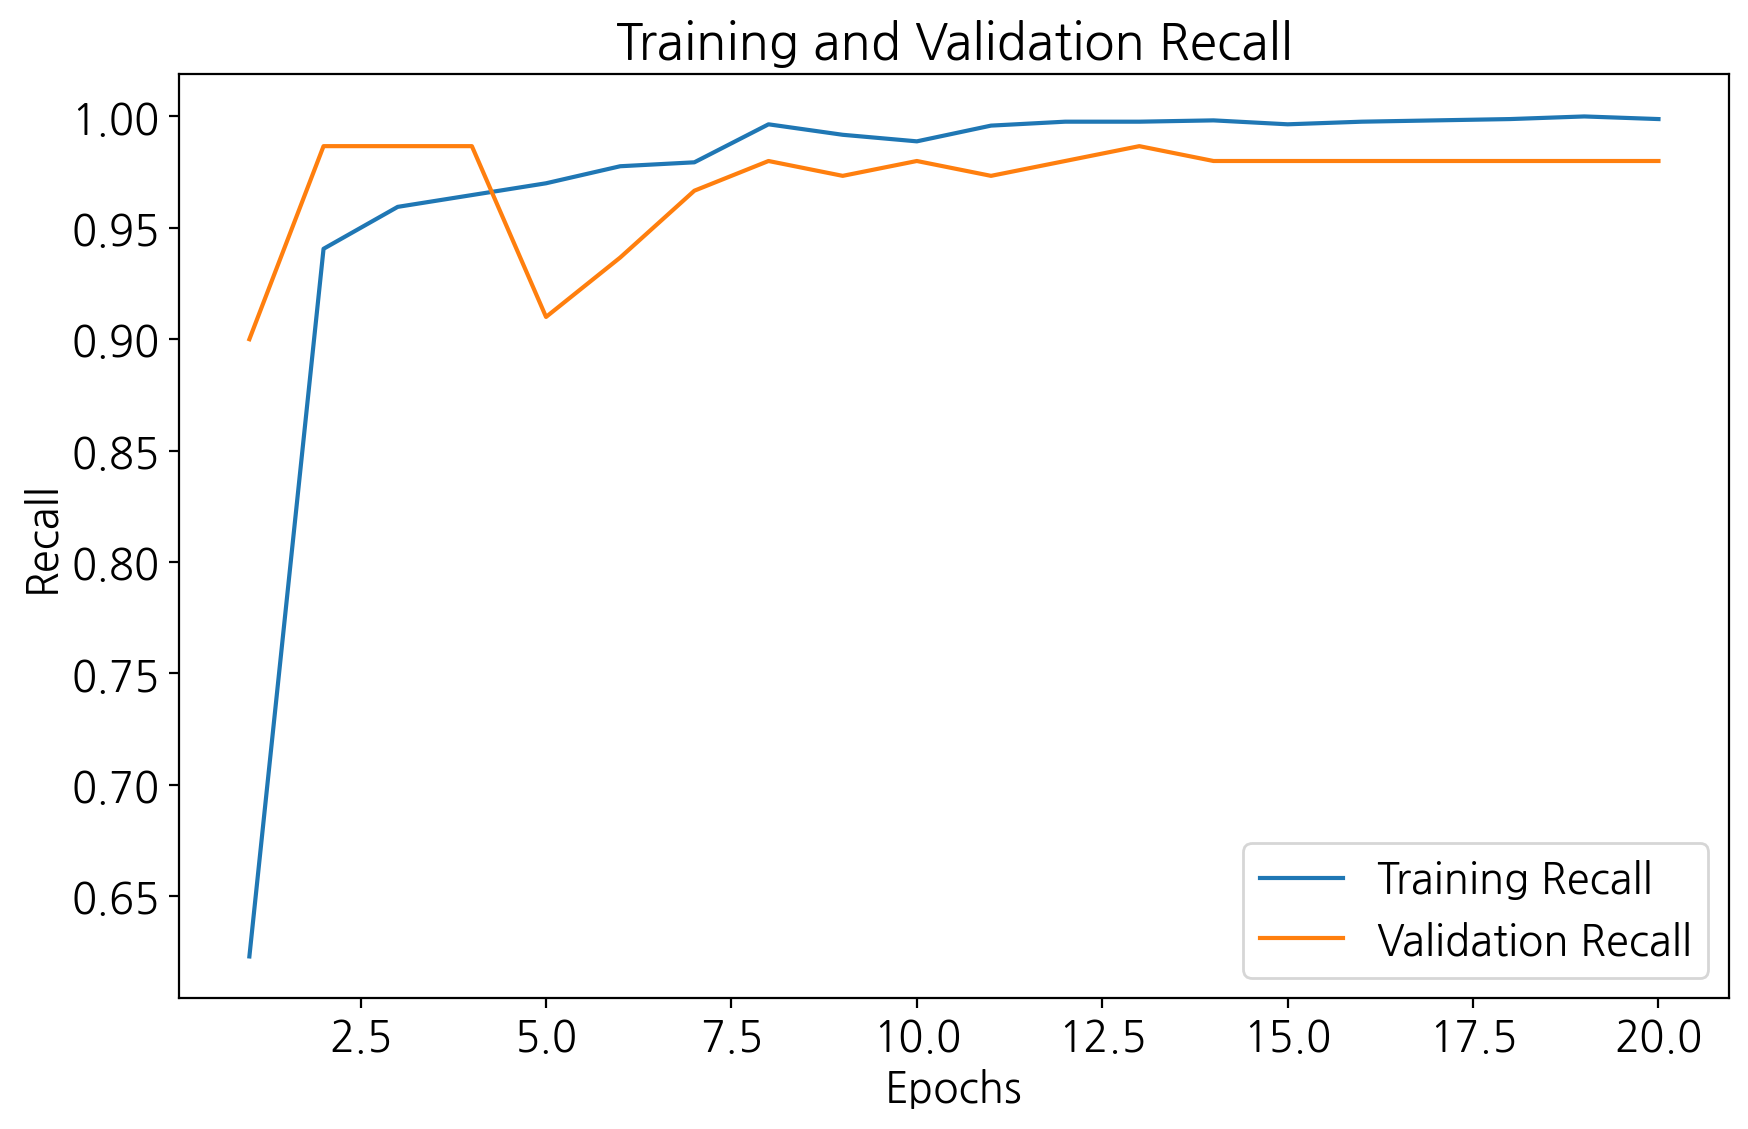

In [35]:
# Train, validation 성능 변화 과정 시각화
plot_training_metrics(history_list[0], epochs)

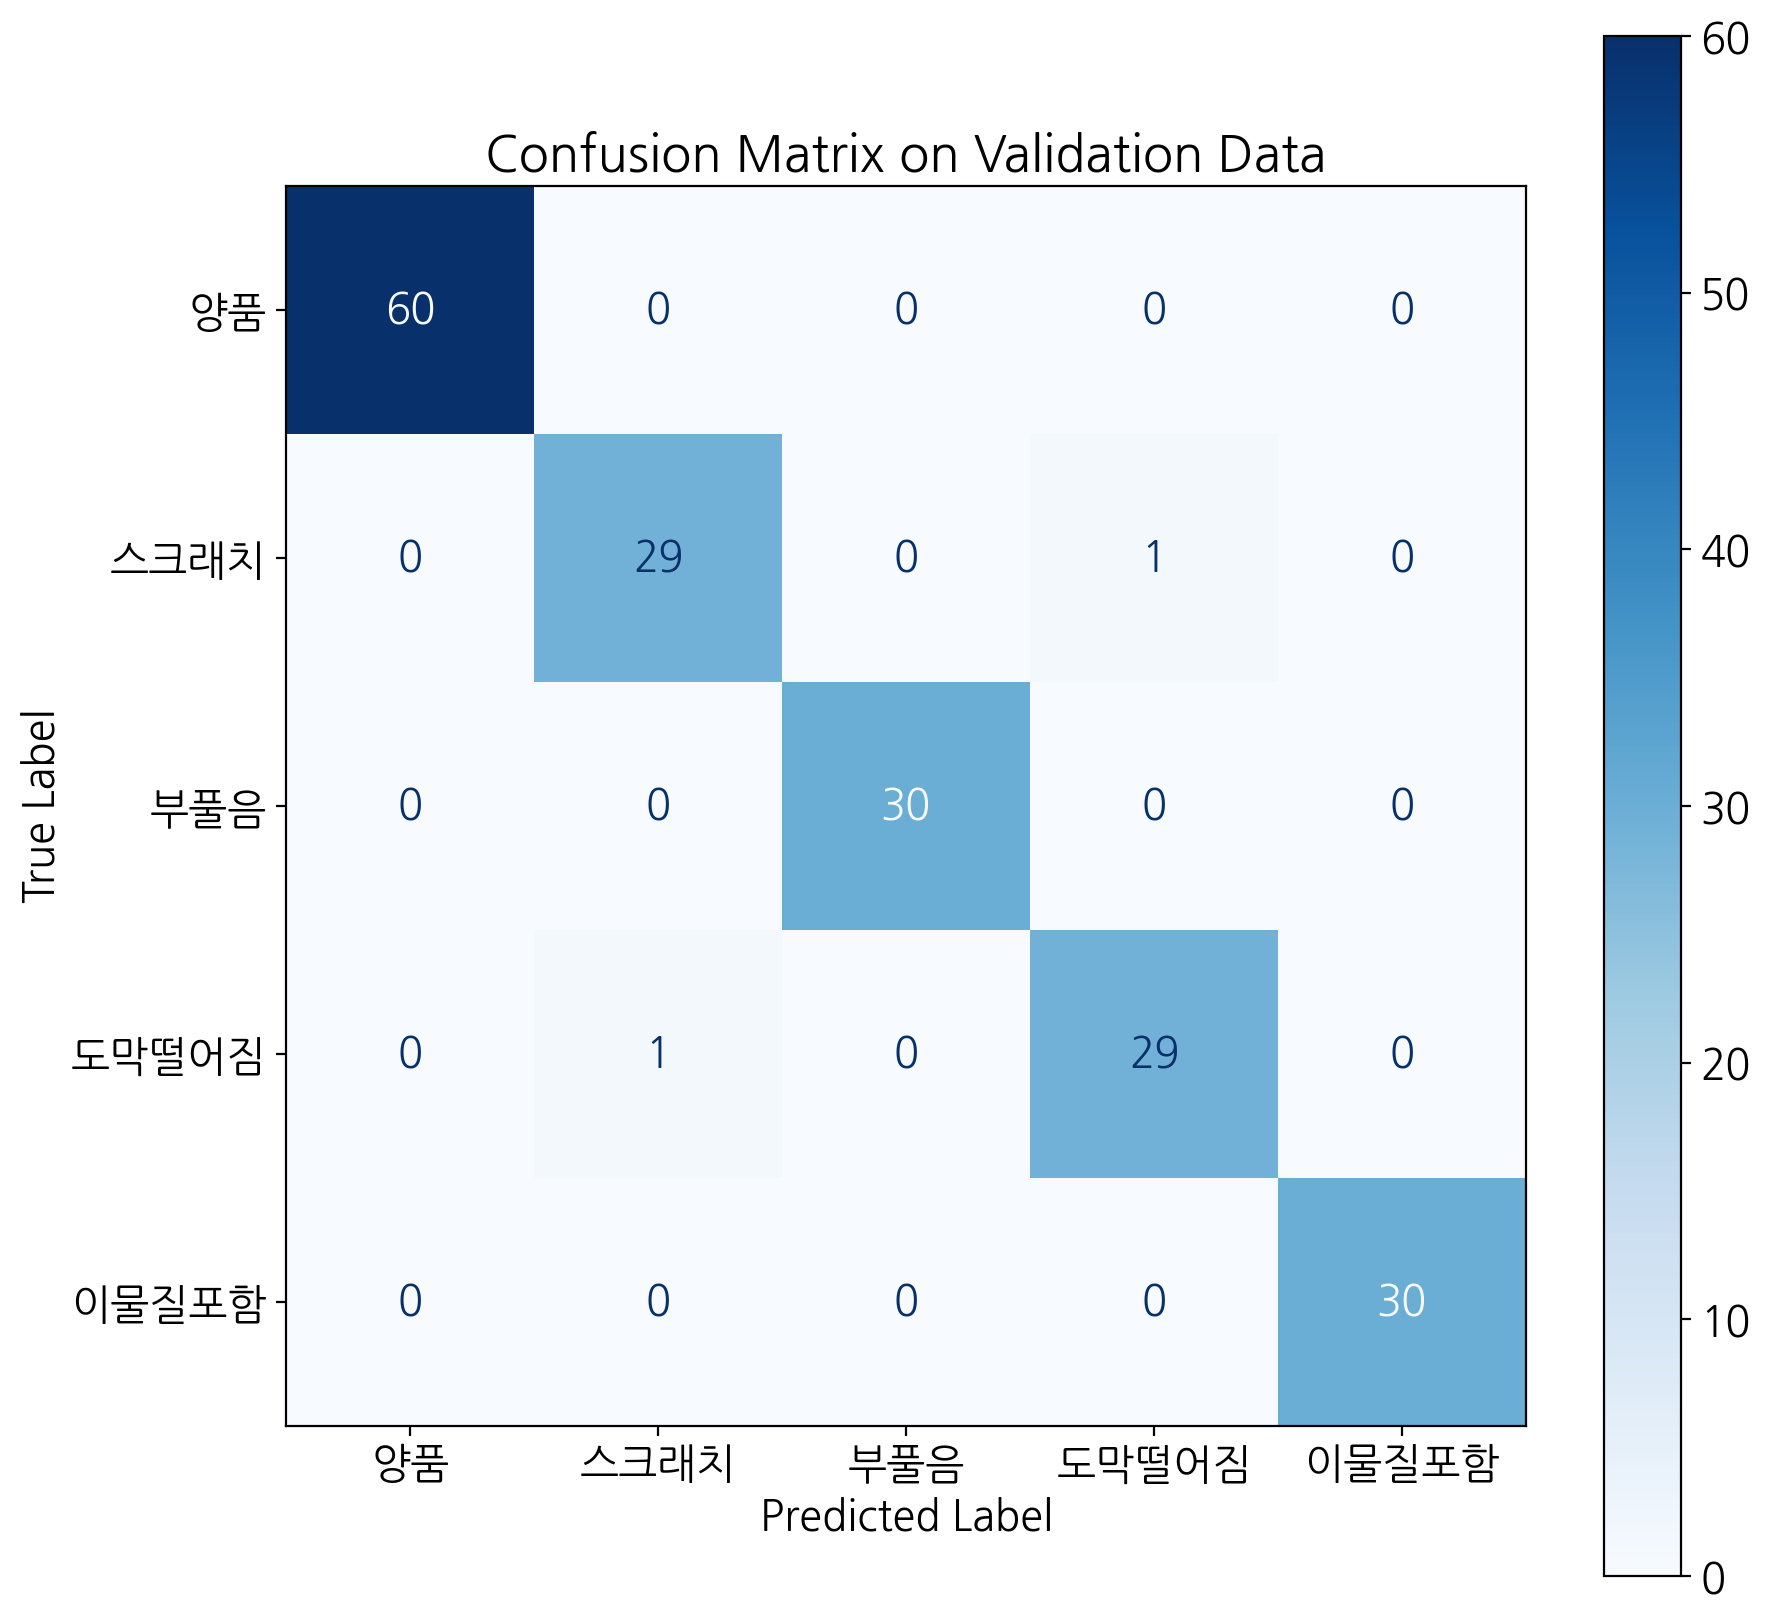

-------------------- Classification Report --------------------
              precision    recall  f1-score   support

          양품       1.00      1.00      1.00        60
        스크래치       0.97      0.97      0.97        30
         부풀음       1.00      1.00      1.00        30
       도막떨어짐       0.97      0.97      0.97        30
       이물질포함       1.00      1.00      1.00        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

---------------------------------------------------------------


In [36]:
# Validation 데이터셋에 대한 Confusion Matrix 및 Classification Report
evaluate_and_plot(
    model=models_list[0],
    loader_valid=loader_valid,
    device=device,
    class_names=class_names_list
)

In [37]:
torch.cuda.empty_cache()

In [38]:
# 두 번째 모델 훈련
model_state_dict, history = train(model=models_list[1],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer2,
                         scheduler=scheduler2,
                         epochs=epochs)

history_list.append(history)

# 두 번째 모델에 최적 가중치 적용
models_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 1.1883
	정확도 : 0.6039 / 정밀도 : 0.6028 / 재현율 : 0.5871 / F1 점수 : 0.5864
	검증 데이터 손실값 : 0.4662
	정확도 : 0.9556 / 정밀도 : 0.9535 / 재현율 : 0.9467 / F1 점수 : 0.9485
	### 검증 F1 점수 증가 (0.0000 --> 0.9485). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2081
	정확도 : 0.9490 / 정밀도 : 0.9467 / 재현율 : 0.9441 / F1 점수 : 0.9452
	검증 데이터 손실값 : 0.1570
	정확도 : 0.9556 / 정밀도 : 0.9514 / 재현율 : 0.9600 / F1 점수 : 0.9548
	### 검증 F1 점수 증가 (0.9485 --> 0.9548). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1177
	정확도 : 0.9706 / 정밀도 : 0.9682 / 재현율 : 0.9671 / F1 점수 : 0.9676
	검증 데이터 손실값 : 0.3714
	정확도 : 0.9278 / 정밀도 : 0.9202 / 재현율 : 0.9367 / F1 점수 : 0.9262
에폭 [4/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1428
	정확도 : 0.9578 / 정밀도 : 0.9569 / 재현율 : 0.9559 / F1 점수 : 0.9562
	검증 데이터 손실값 : 0.0671
	정확도 : 0.9889 / 정밀도 : 0.9867 / 재현율 : 0.9867 / F1 점수 : 0.9867
	### 검증 F1 점수 증가 (0.9548 --> 0.9867). 모델 저장
에폭 [5/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0877
	정확도 : 0.9725 / 정밀도 : 0.9695 / 재현율 : 0.9700 / F1 점수 : 0.9697
	검증 데이터 손실값 : 0.1434
	정확도 : 0.9667 / 정밀도 : 0.9622 / 재현율 : 0.9667 / F1 점수 : 0.9635
에폭 [6/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0659
	정확도 : 0.9853 / 정밀도 : 0.9841 / 재현율 : 0.9824 / F1 점수 : 0.9832
	검증 데이터 손실값 : 0.0770
	정확도 : 0.9833 / 정밀도 : 0.9802 / 재현율 : 0.9800 / F1 점수 : 0.9800
에폭 [7/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0723
	정확도 : 0.9853 / 정밀도 : 0.9841 / 재현율 : 0.9841 / F1 점수 : 0.9841
	검증 데이터 손실값 : 0.1362
	정확도 : 0.9833 / 정밀도 : 0.9818 / 재현율 : 0.9800 / F1 점수 : 0.9799
에폭 [8/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0282
	정확도 : 0.9931 / 정밀도 : 0.9918 / 재현율 : 0.9924 / F1 점수 : 0.9921
	검증 데이터 손실값 : 0.0160
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9867 --> 0.9933). 모델 저장
에폭 [9/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0162
	정확도 : 0.9931 / 정밀도 : 0.9930 / 재현율 : 0.9924 / F1 점수 : 0.9926
	검증 데이터 손실값 : 0.0053
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [10/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0083
	정확도 : 0.9971 / 정밀도 : 0.9971 / 재현율 : 0.9971 / F1 점수 : 0.9971
	검증 데이터 손실값 : 0.0109
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [11/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0177
	정확도 : 0.9961 / 정밀도 : 0.9959 / 재현율 : 0.9959 / F1 점수 : 0.9959
	검증 데이터 손실값 : 0.0071
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [12/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0061
	정확도 : 0.9990 / 정밀도 : 0.9988 / 재현율 : 0.9988 / F1 점수 : 0.9988
	검증 데이터 손실값 : 0.0120
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [13/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0070
	정확도 : 0.9980 / 정밀도 : 0.9977 / 재현율 : 0.9976 / F1 점수 : 0.9976
	검증 데이터 손실값 : 0.0079
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [14/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0032
	정확도 : 0.9990 / 정밀도 : 0.9988 / 재현율 : 0.9988 / F1 점수 : 0.9988
	검증 데이터 손실값 : 0.0261
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [15/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0023
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0199
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [16/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0034
	정확도 : 0.9990 / 정밀도 : 0.9994 / 재현율 : 0.9988 / F1 점수 : 0.9991
	검증 데이터 손실값 : 0.0199
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [17/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0021
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0227
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [18/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0036
	정확도 : 0.9990 / 정밀도 : 0.9988 / 재현율 : 0.9988 / F1 점수 : 0.9988
	검증 데이터 손실값 : 0.0222
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [19/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0032
	정확도 : 0.9990 / 정밀도 : 0.9988 / 재현율 : 0.9988 / F1 점수 : 0.9988
	검증 데이터 손실값 : 0.0228
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장
에폭 [20/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0051
	정확도 : 0.9980 / 정밀도 : 0.9977 / 재현율 : 0.9976 / F1 점수 : 0.9976
	검증 데이터 손실값 : 0.0227
	정확도 : 0.9944 / 정밀도 : 0.9935 / 재현율 : 0.9933 / F1 점수 : 0.9933
	### 검증 F1 점수 증가 (0.9933 --> 0.9933). 모델 저장


<All keys matched successfully>

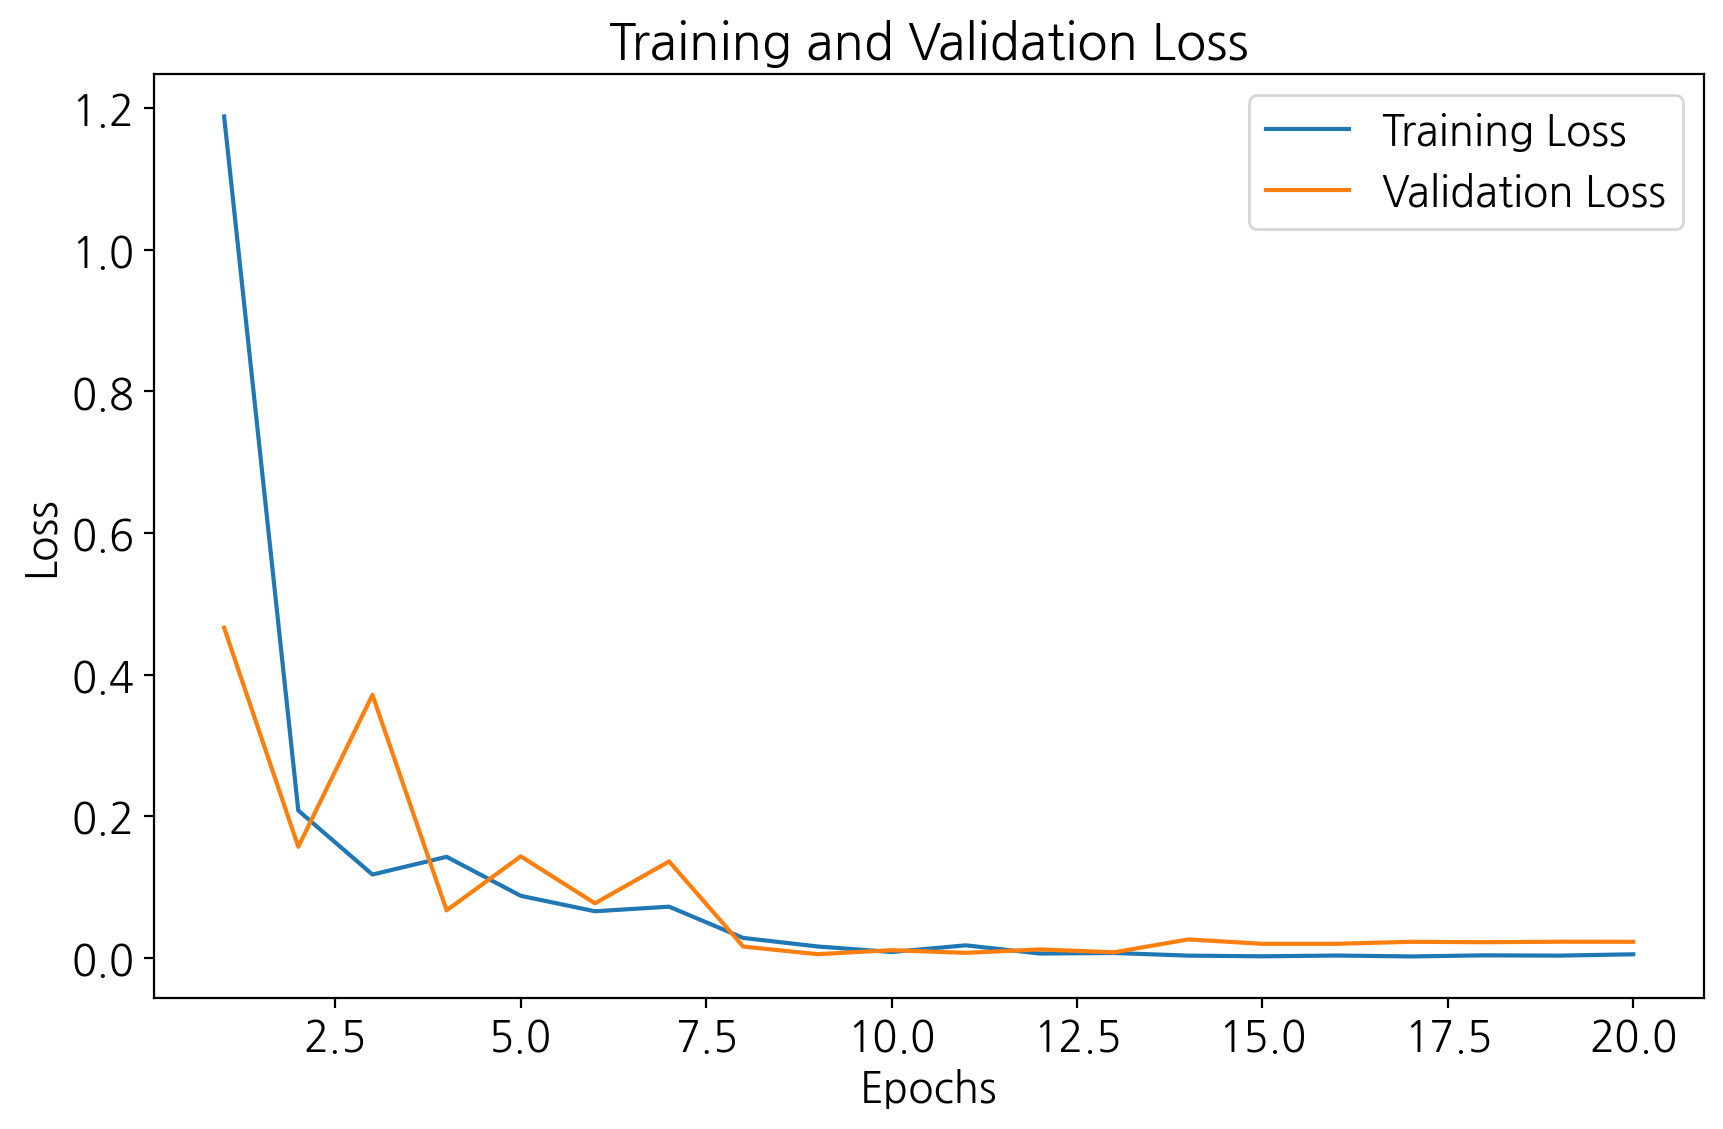

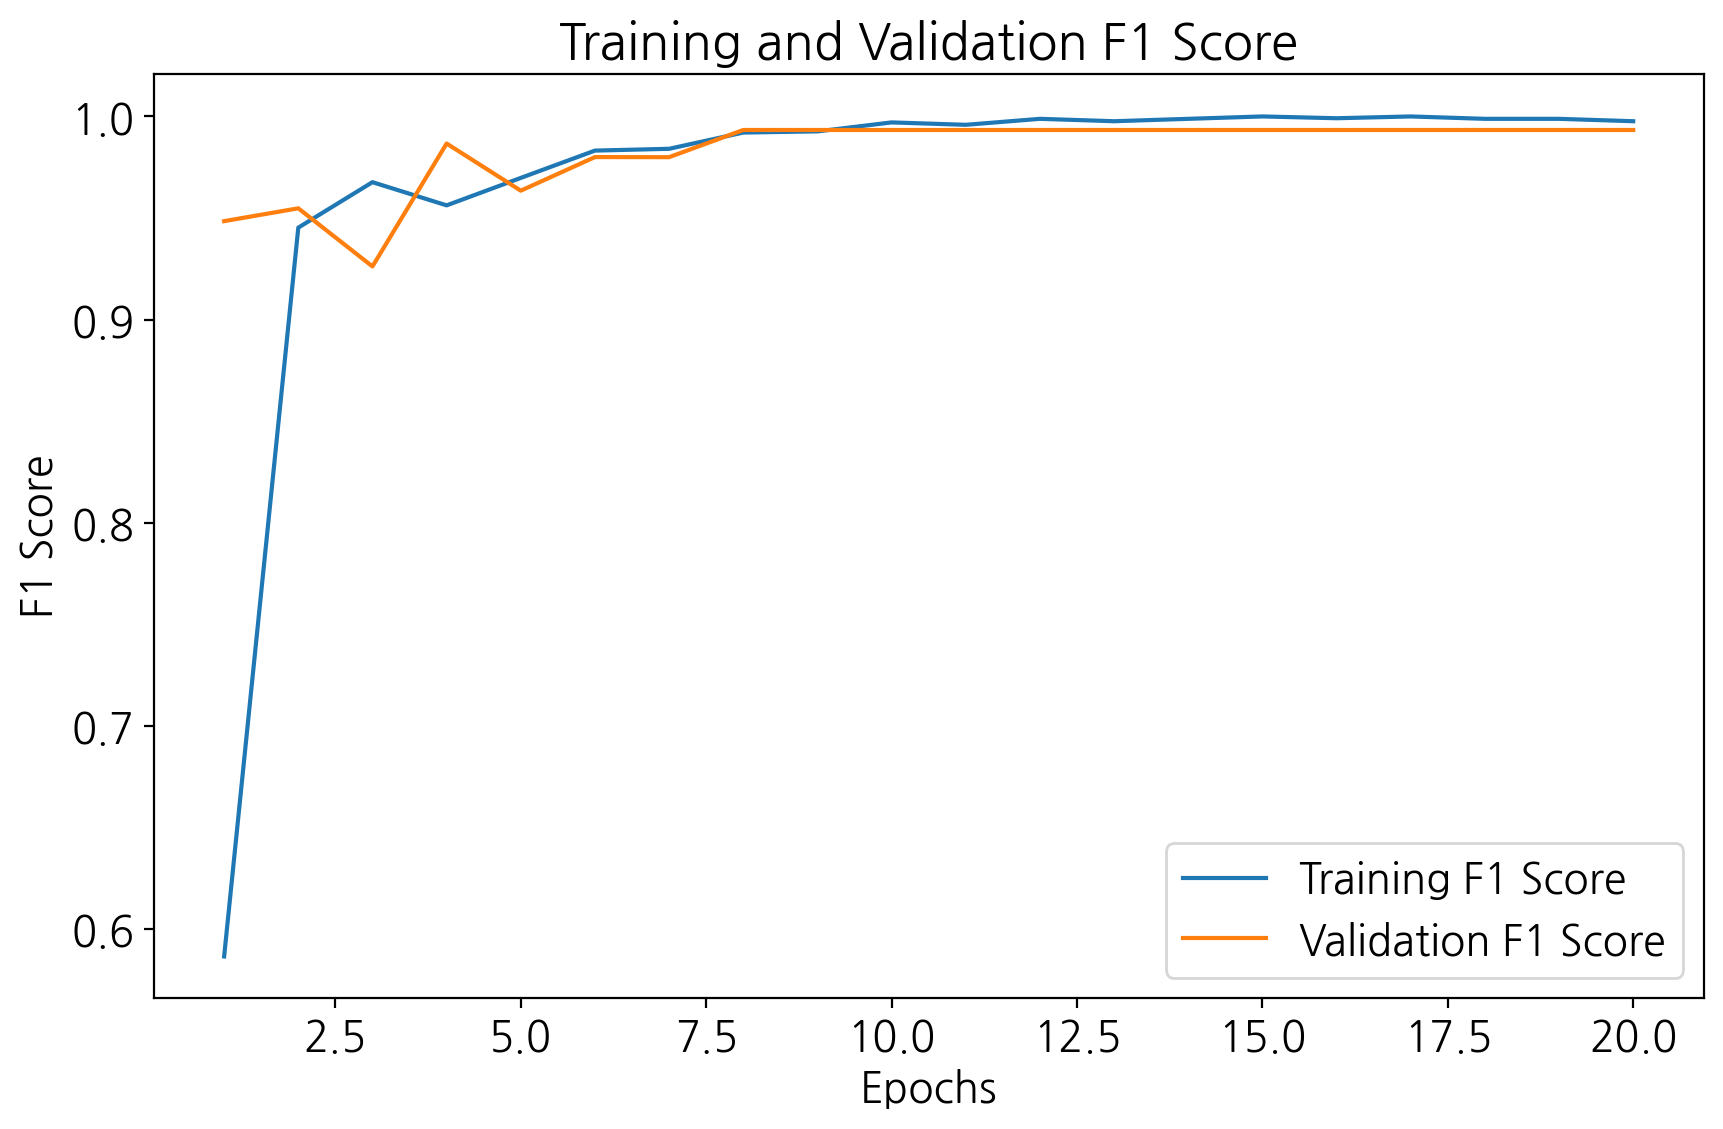

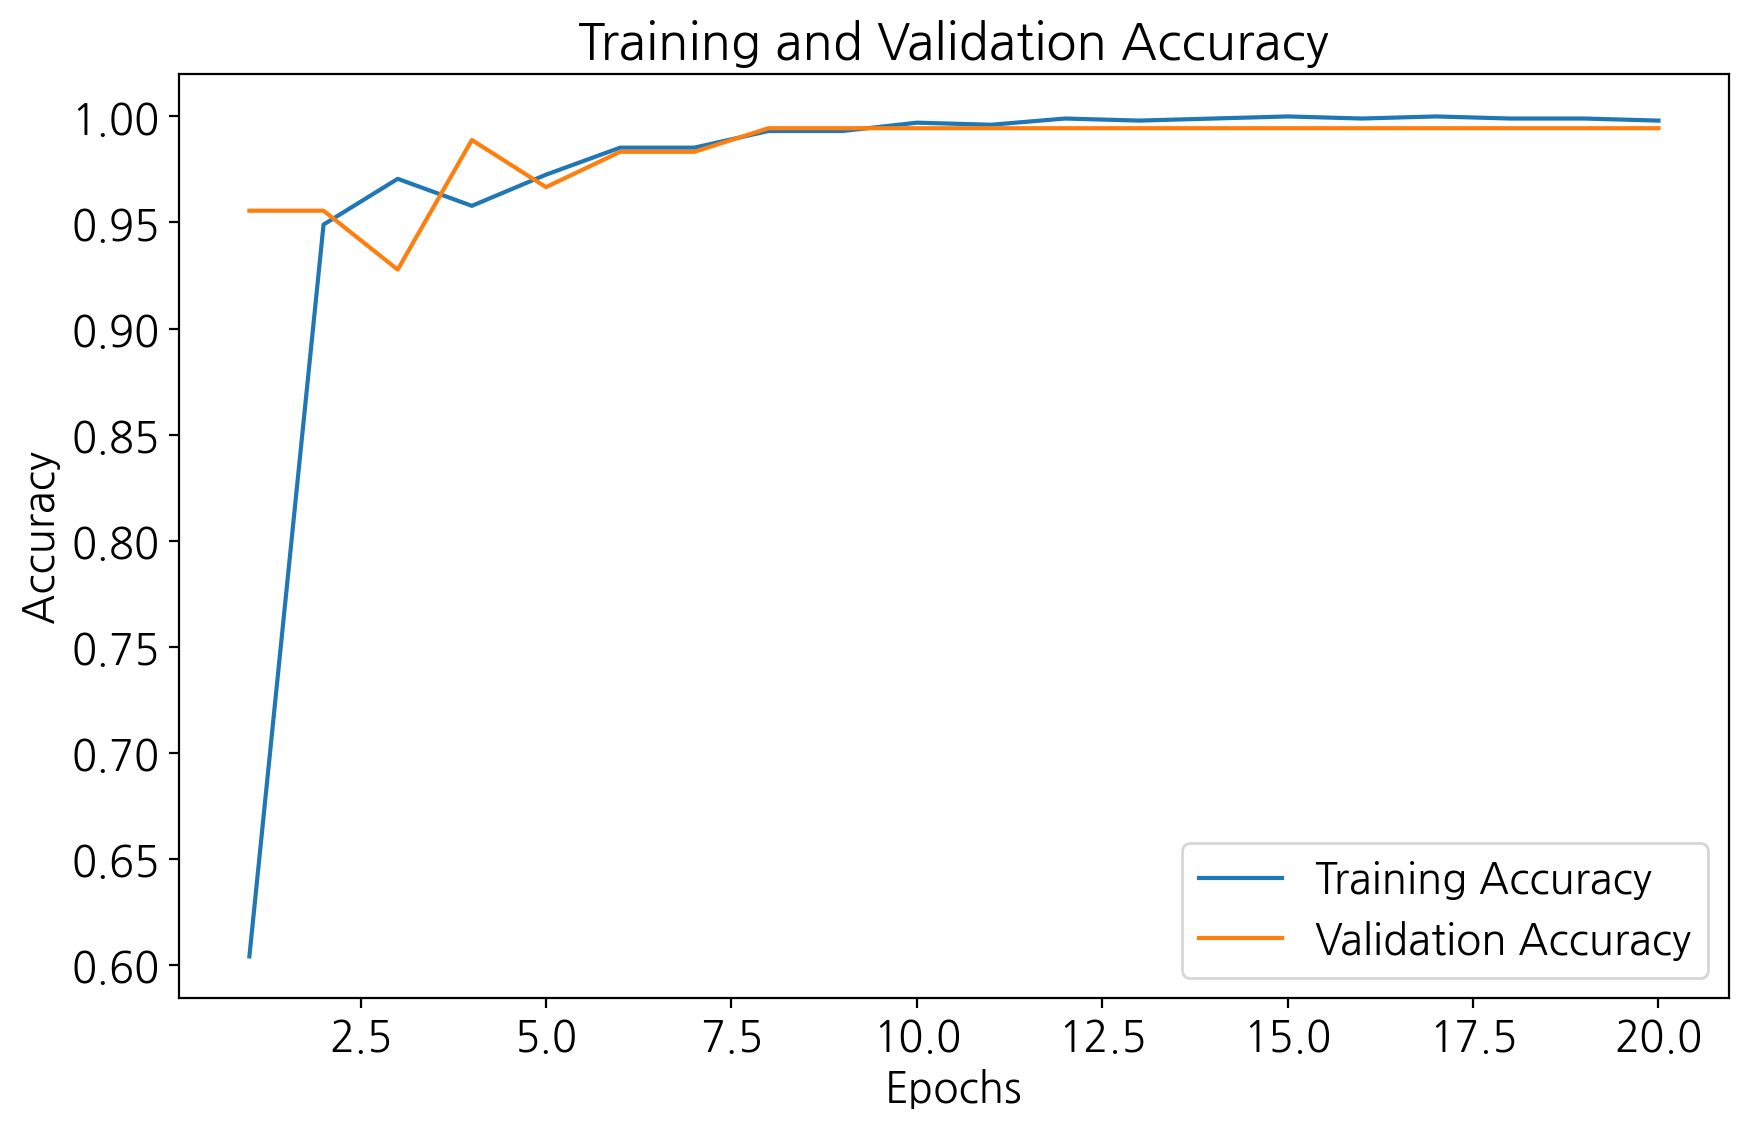

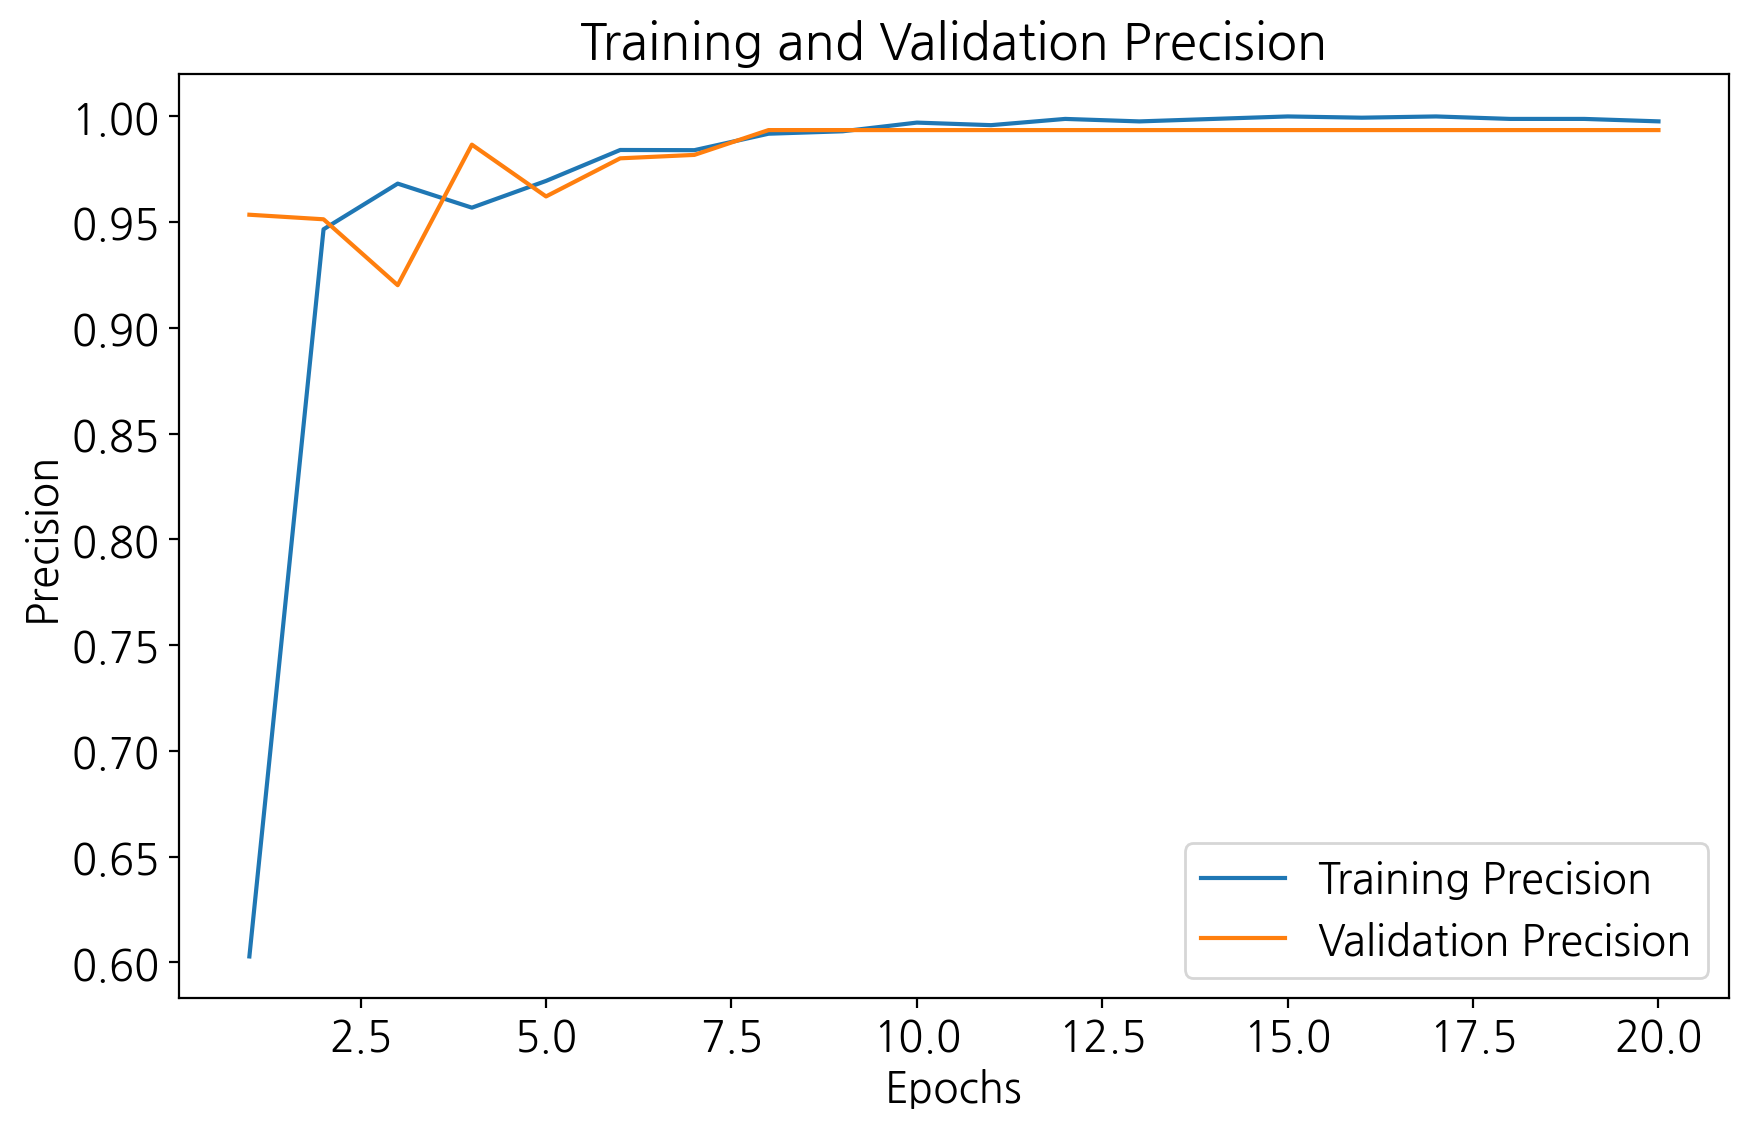

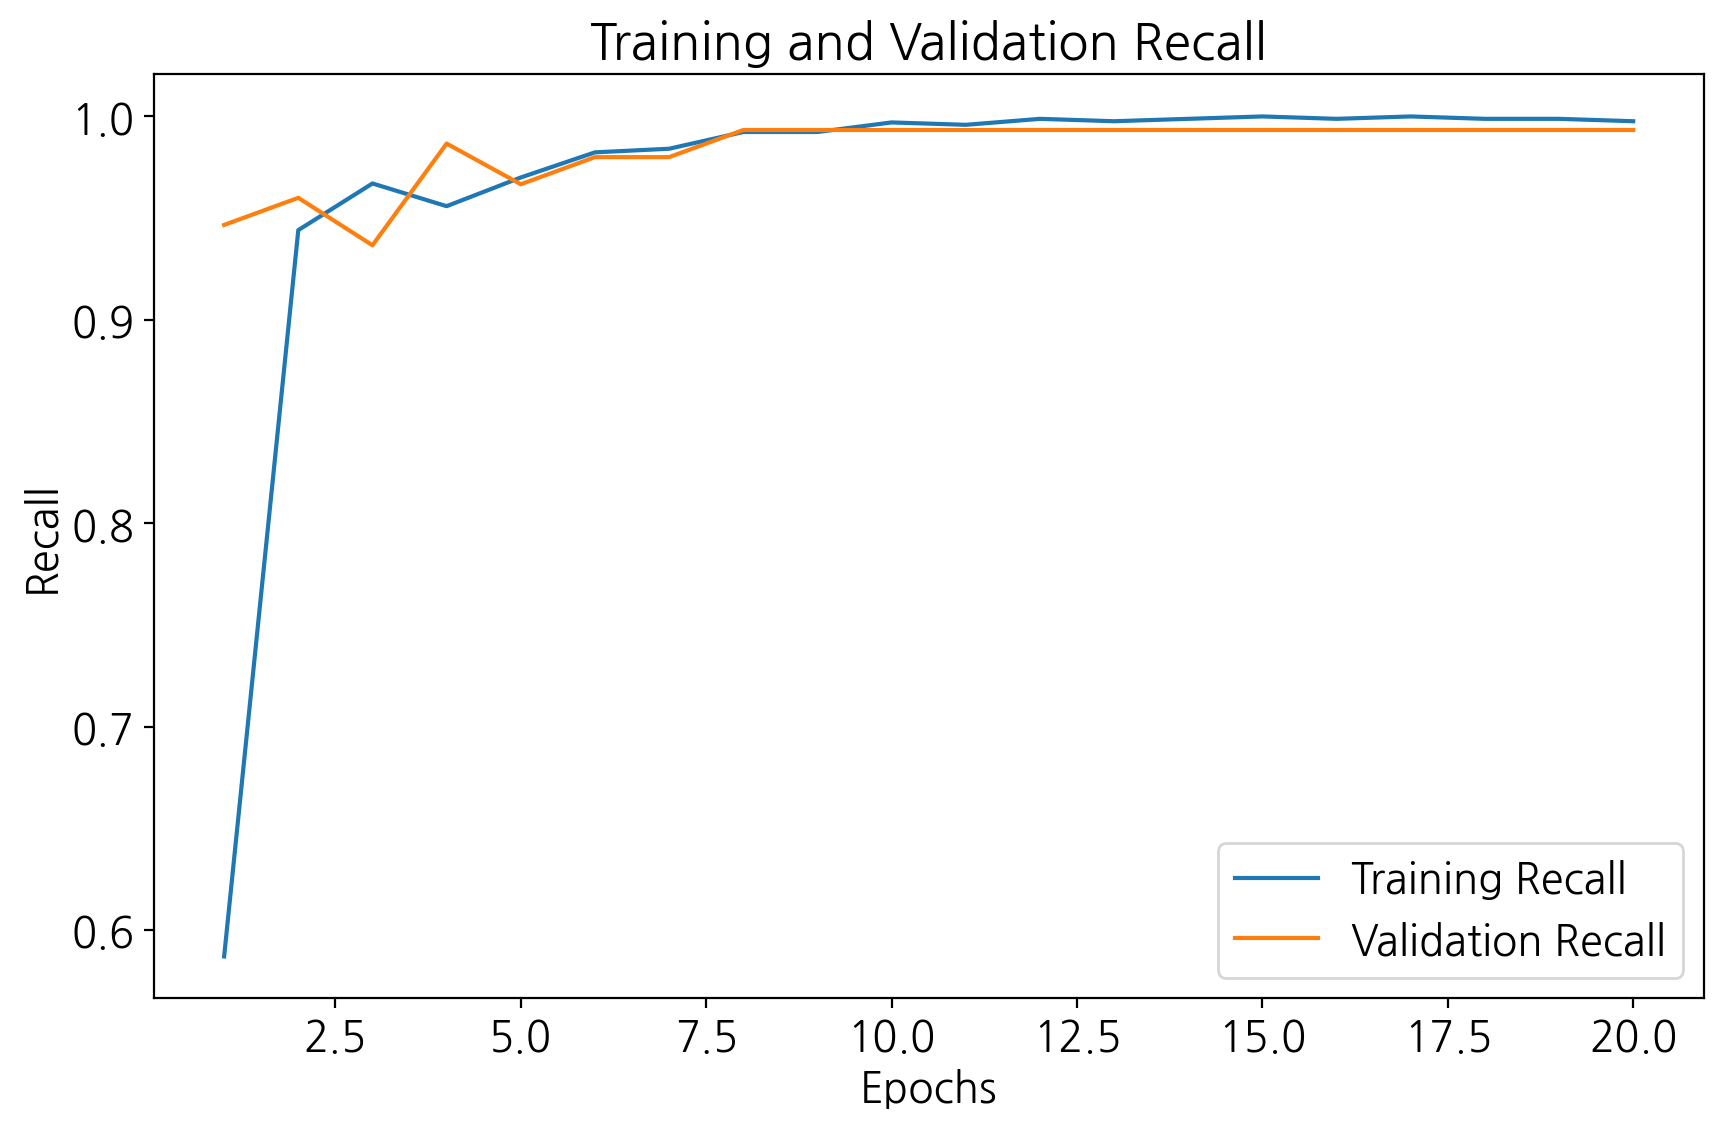

In [39]:
# Train, validation 성능 변화 과정 시각화
plot_training_metrics(history_list[1], epochs)

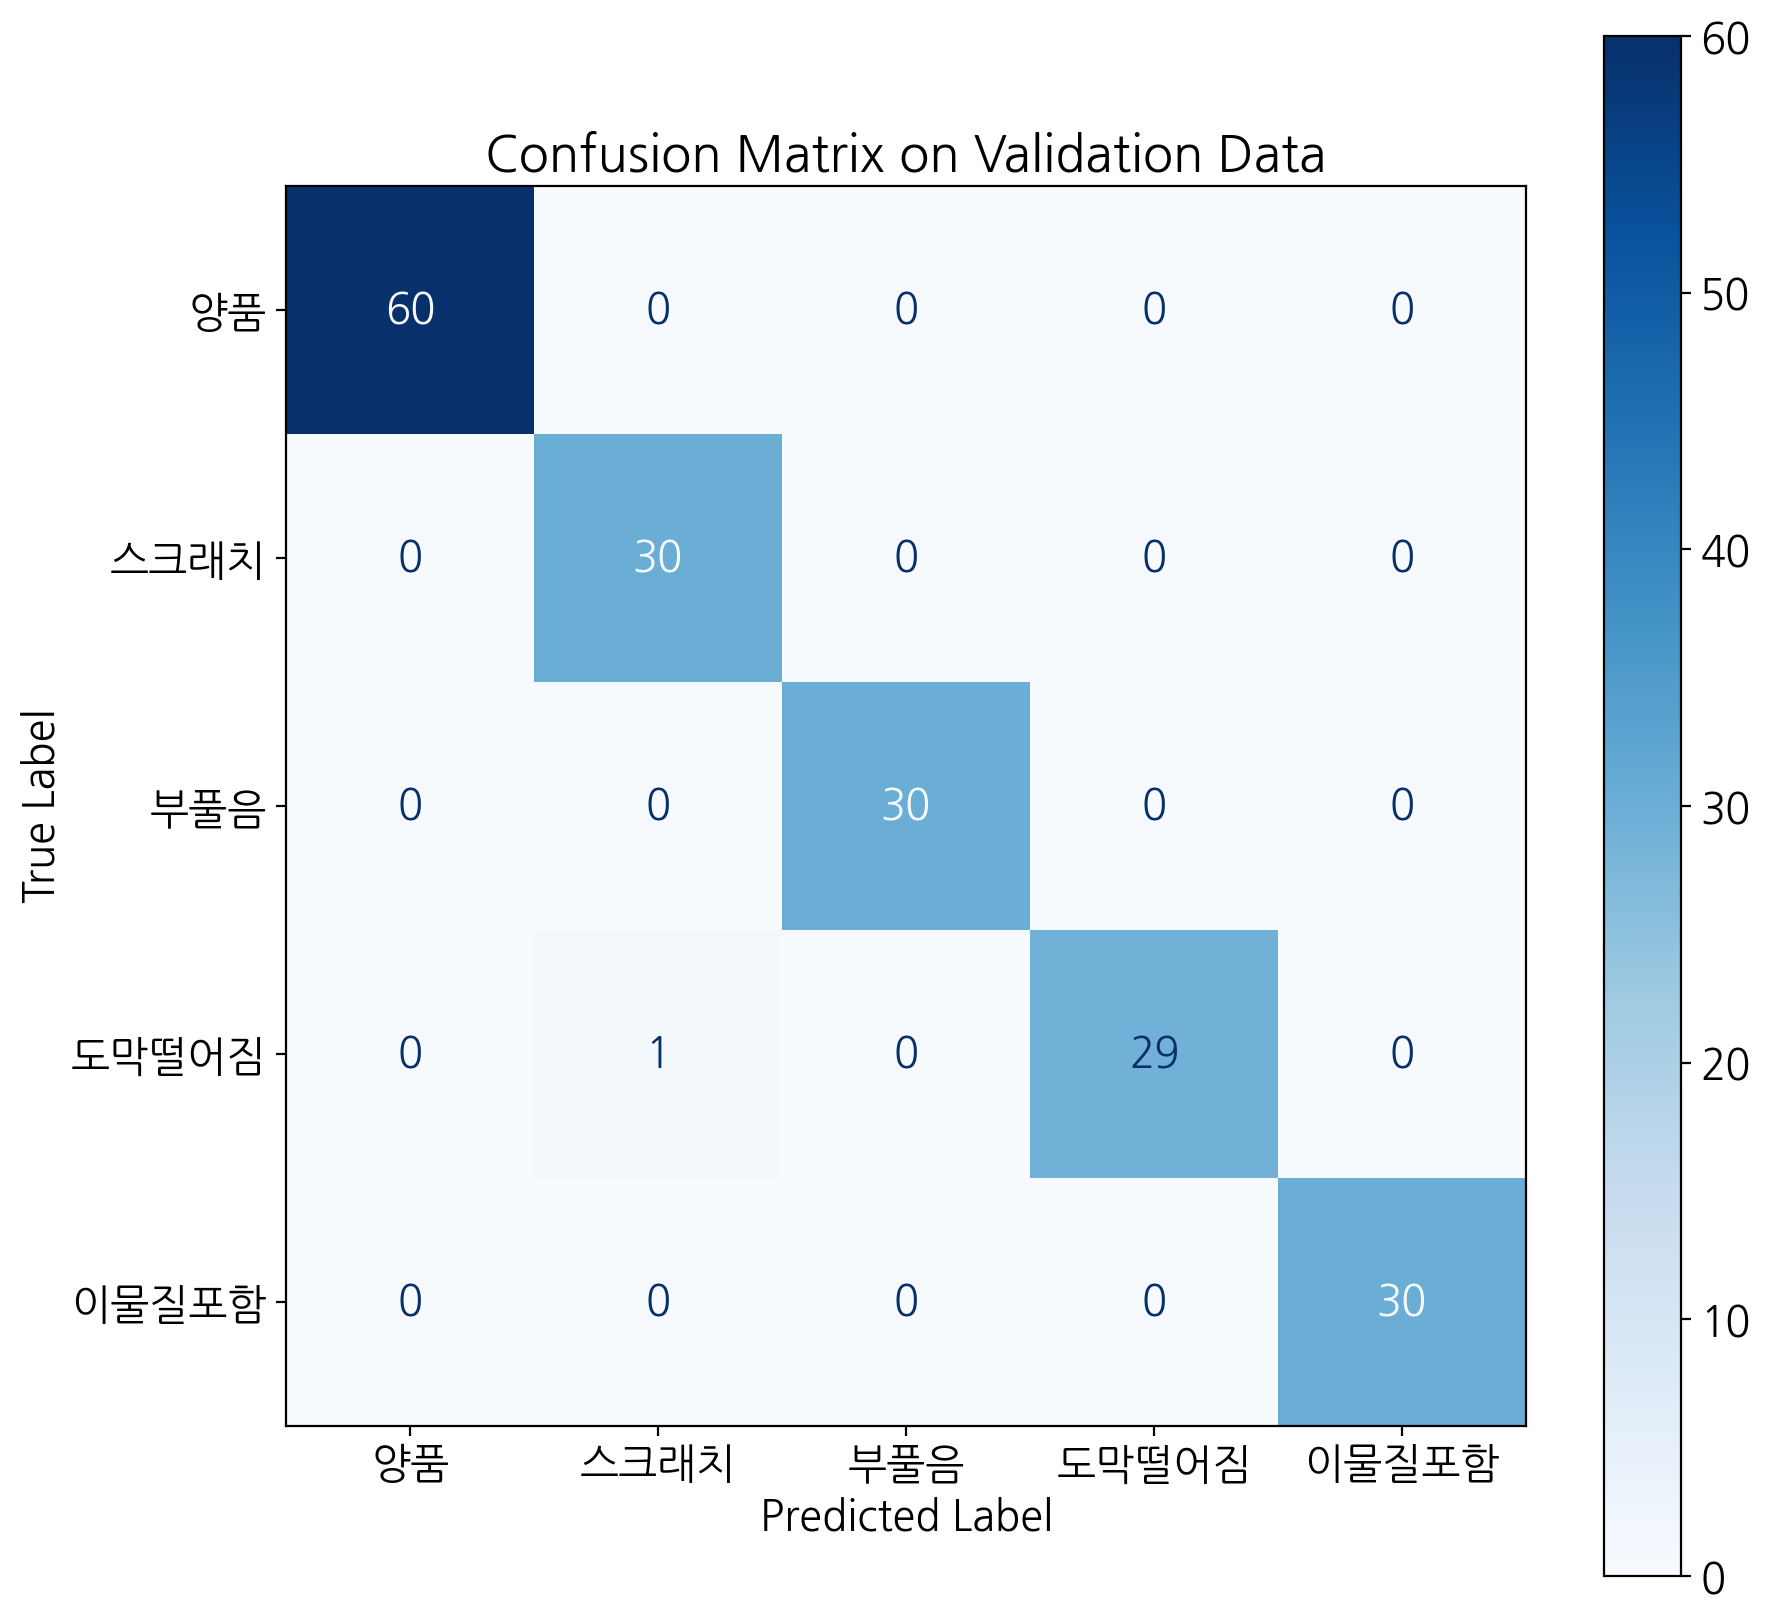

-------------------- Classification Report --------------------
              precision    recall  f1-score   support

          양품       1.00      1.00      1.00        60
        스크래치       0.97      1.00      0.98        30
         부풀음       1.00      1.00      1.00        30
       도막떨어짐       1.00      0.97      0.98        30
       이물질포함       1.00      1.00      1.00        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

---------------------------------------------------------------


In [40]:
# Validation 데이터셋에 대한 Confusion Matrix 및 Classification Report
evaluate_and_plot(
    model=models_list[1],
    loader_valid=loader_valid,
    device=device,
    class_names=class_names_list
)

In [41]:
torch.cuda.empty_cache()

In [42]:
# 세 번째 모델 훈련
model_state_dict, history = train(model=models_list[2],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer3,
                         scheduler=scheduler3,
                         epochs=epochs)

history_list.append(history)

# 세 번째 모델에 최적 가중치 적용
models_list[2].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 1.0904
	정확도 : 0.6794 / 정밀도 : 0.6786 / 재현율 : 0.6776 / F1 점수 : 0.6737
	검증 데이터 손실값 : 0.4166
	정확도 : 0.9389 / 정밀도 : 0.9459 / 재현율 : 0.9267 / F1 점수 : 0.9344
	### 검증 F1 점수 증가 (0.0000 --> 0.9344). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2005
	정확도 : 0.9412 / 정밀도 : 0.9357 / 재현율 : 0.9353 / F1 점수 : 0.9355
	검증 데이터 손실값 : 0.0783
	정확도 : 0.9833 / 정밀도 : 0.9804 / 재현율 : 0.9867 / F1 점수 : 0.9834
	### 검증 F1 점수 증가 (0.9344 --> 0.9834). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0944
	정확도 : 0.9716 / 정밀도 : 0.9700 / 재현율 : 0.9694 / F1 점수 : 0.9697
	검증 데이터 손실값 : 0.2049
	정확도 : 0.9611 / 정밀도 : 0.9568 / 재현율 : 0.9667 / F1 점수 : 0.9604
에폭 [4/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1785
	정확도 : 0.9461 / 정밀도 : 0.9421 / 재현율 : 0.9394 / F1 점수 : 0.9407
	검증 데이터 손실값 : 0.1293
	정확도 : 0.9778 / 정밀도 : 0.9737 / 재현율 : 0.9767 / F1 점수 : 0.9750
에폭 [5/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0750
	정확도 : 0.9745 / 정밀도 : 0.9723 / 재현율 : 0.9718 / F1 점수 : 0.9720
	검증 데이터 손실값 : 0.0650
	정확도 : 0.9889 / 정밀도 : 0.9875 / 재현율 : 0.9867 / F1 점수 : 0.9867
	### 검증 F1 점수 증가 (0.9834 --> 0.9867). 모델 저장
에폭 [6/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0632
	정확도 : 0.9833 / 정밀도 : 0.9818 / 재현율 : 0.9806 / F1 점수 : 0.9812
	검증 데이터 손실값 : 0.1292
	정확도 : 0.9667 / 정밀도 : 0.9667 / 재현율 : 0.9600 / F1 점수 : 0.9596
에폭 [7/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0600
	정확도 : 0.9853 / 정밀도 : 0.9842 / 재현율 : 0.9841 / F1 점수 : 0.9841
	검증 데이터 손실값 : 0.0462
	정확도 : 0.9833 / 정밀도 : 0.9806 / 재현율 : 0.9833 / F1 점수 : 0.9817
에폭 [8/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0454
	정확도 : 0.9892 / 정밀도 : 0.9883 / 재현율 : 0.9888 / F1 점수 : 0.9885
	검증 데이터 손실값 : 0.0590
	정확도 : 0.9833 / 정밀도 : 0.9806 / 재현율 : 0.9833 / F1 점수 : 0.9817
에폭 [9/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0306
	정확도 : 0.9892 / 정밀도 : 0.9900 / 재현율 : 0.9876 / F1 점수 : 0.9888
	검증 데이터 손실값 : 0.0589
	정확도 : 0.9889 / 정밀도 : 0.9869 / 재현율 : 0.9900 / F1 점수 : 0.9884
	### 검증 F1 점수 증가 (0.9867 --> 0.9884). 모델 저장
에폭 [10/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0601
	정확도 : 0.9814 / 정밀도 : 0.9800 / 재현율 : 0.9812 / F1 점수 : 0.9806
	검증 데이터 손실값 : 0.0444
	정확도 : 0.9889 / 정밀도 : 0.9875 / 재현율 : 0.9867 / F1 점수 : 0.9867
에폭 [11/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0124
	정확도 : 0.9980 / 정밀도 : 0.9977 / 재현율 : 0.9982 / F1 점수 : 0.9979
	검증 데이터 손실값 : 0.0489
	정확도 : 0.9833 / 정밀도 : 0.9842 / 재현율 : 0.9800 / F1 점수 : 0.9814
에폭 [12/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0184
	정확도 : 0.9971 / 정밀도 : 0.9965 / 재현율 : 0.9971 / F1 점수 : 0.9968
	검증 데이터 손실값 : 0.0477
	정확도 : 0.9889 / 정밀도 : 0.9875 / 재현율 : 0.9867 / F1 점수 : 0.9867
에폭 [13/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0123
	정확도 : 0.9980 / 정밀도 : 0.9982 / 재현율 : 0.9976 / F1 점수 : 0.9979
	검증 데이터 손실값 : 0.0729
	정확도 : 0.9889 / 정밀도 : 0.9869 / 재현율 : 0.9900 / F1 점수 : 0.9884
	### 검증 F1 점수 증가 (0.9884 --> 0.9884). 모델 저장
에폭 [14/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0035
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0772
	정확도 : 0.9833 / 정밀도 : 0.9806 / 재현율 : 0.9833 / F1 점수 : 0.9817
에폭 [15/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0020
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0813
	정확도 : 0.9833 / 정밀도 : 0.9806 / 재현율 : 0.9833 / F1 점수 : 0.9817
에폭 [16/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0042
	정확도 : 0.9980 / 정밀도 : 0.9982 / 재현율 : 0.9976 / F1 점수 : 0.9979
	검증 데이터 손실값 : 0.0796
	정확도 : 0.9889 / 정밀도 : 0.9869 / 재현율 : 0.9900 / F1 점수 : 0.9884
	### 검증 F1 점수 증가 (0.9884 --> 0.9884). 모델 저장
에폭 [17/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0035
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0704
	정확도 : 0.9889 / 정밀도 : 0.9869 / 재현율 : 0.9900 / F1 점수 : 0.9884
	### 검증 F1 점수 증가 (0.9884 --> 0.9884). 모델 저장
에폭 [18/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0047
	정확도 : 0.9980 / 정밀도 : 0.9977 / 재현율 : 0.9976 / F1 점수 : 0.9976
	검증 데이터 손실값 : 0.0754
	정확도 : 0.9833 / 정밀도 : 0.9806 / 재현율 : 0.9833 / F1 점수 : 0.9817
에폭 [19/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0021
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0869
	정확도 : 0.9833 / 정밀도 : 0.9806 / 재현율 : 0.9833 / F1 점수 : 0.9817
에폭 [20/20] 
-----------------------------


  0%|          | 0/64 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0030
	정확도 : 1.0000 / 정밀도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	검증 데이터 손실값 : 0.0849
	정확도 : 0.9833 / 정밀도 : 0.9806 / 재현율 : 0.9833 / F1 점수 : 0.9817


<All keys matched successfully>

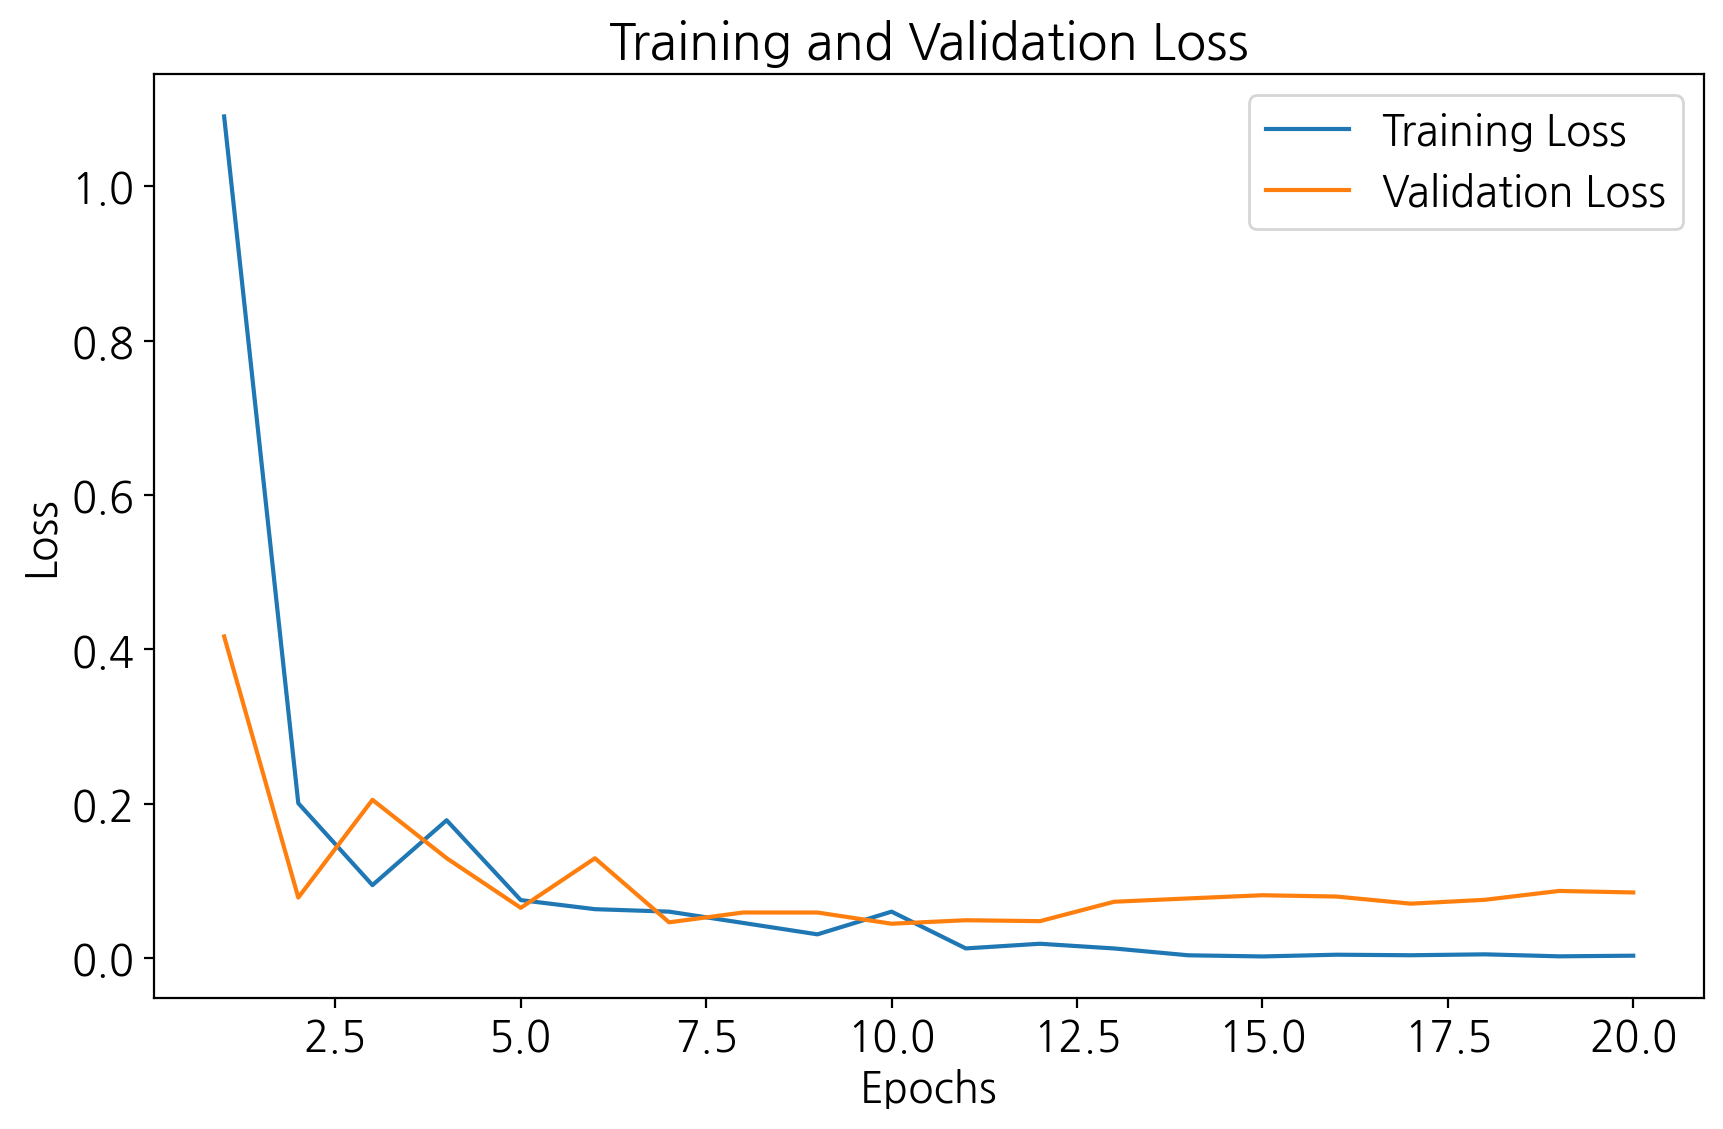

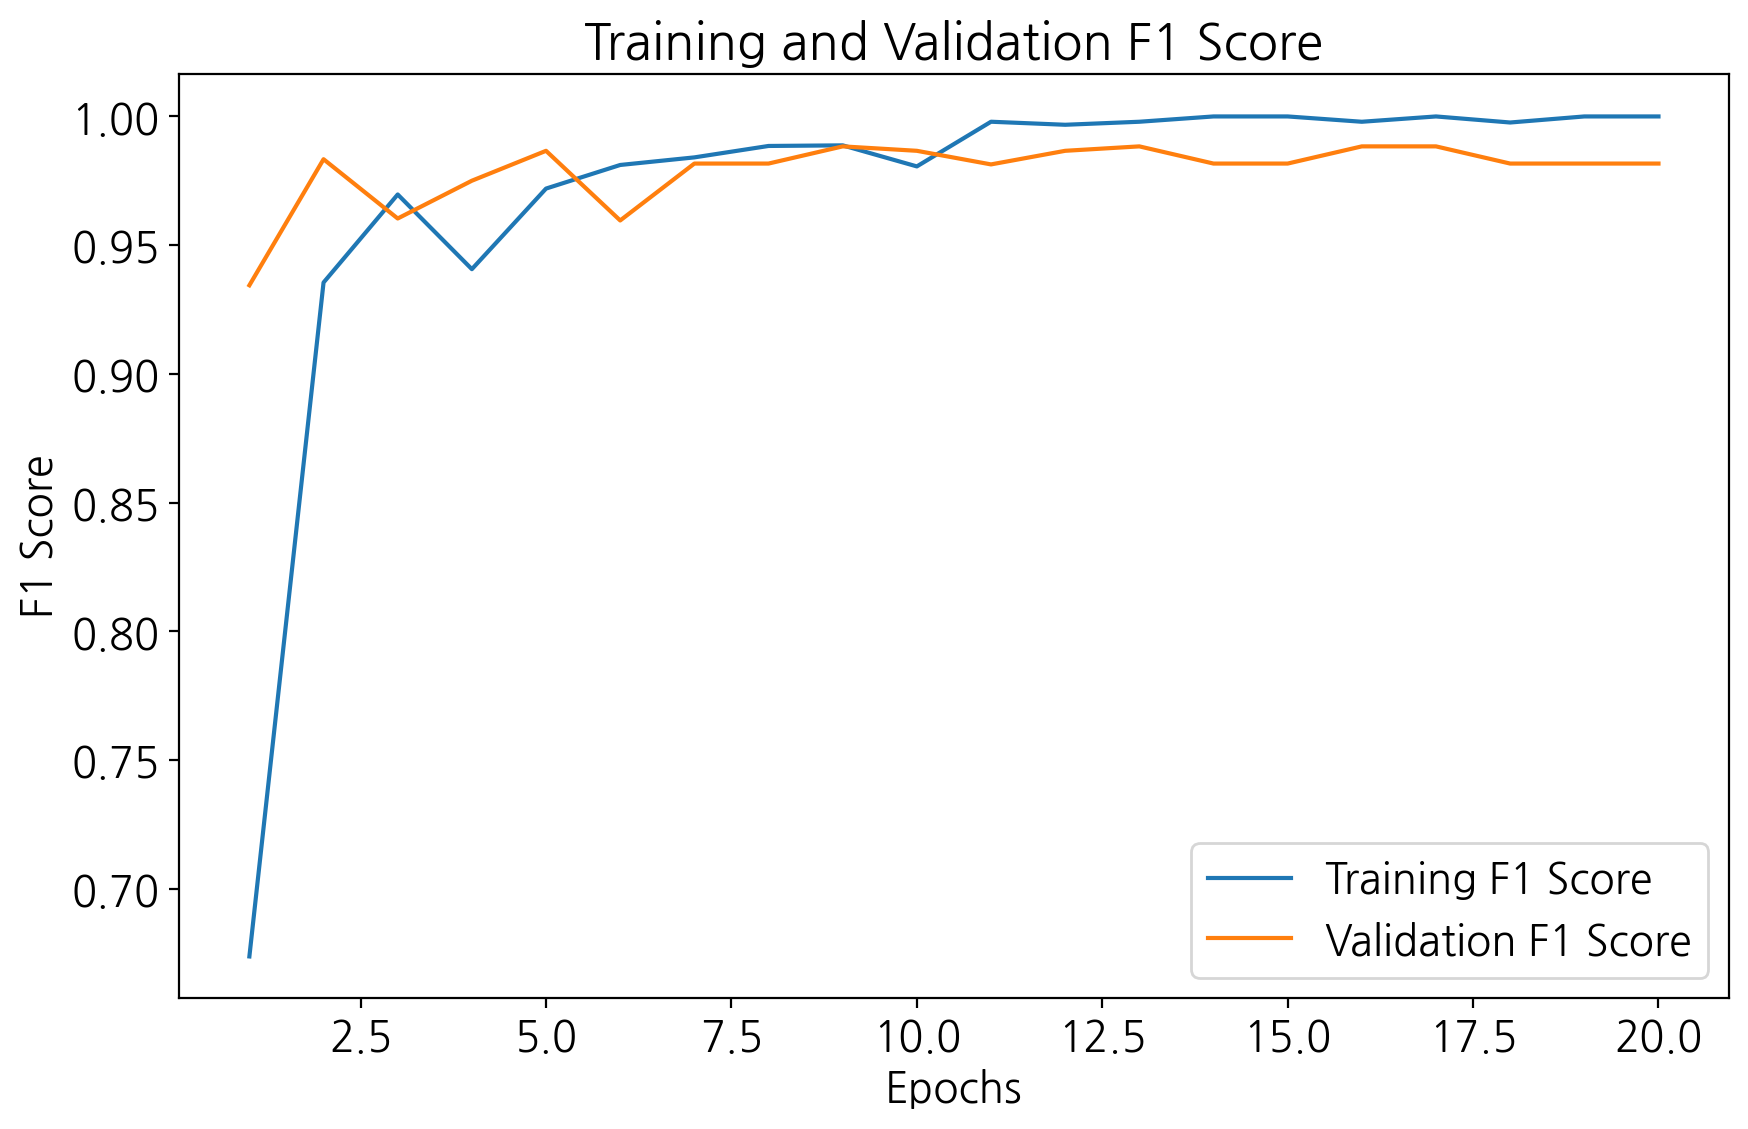

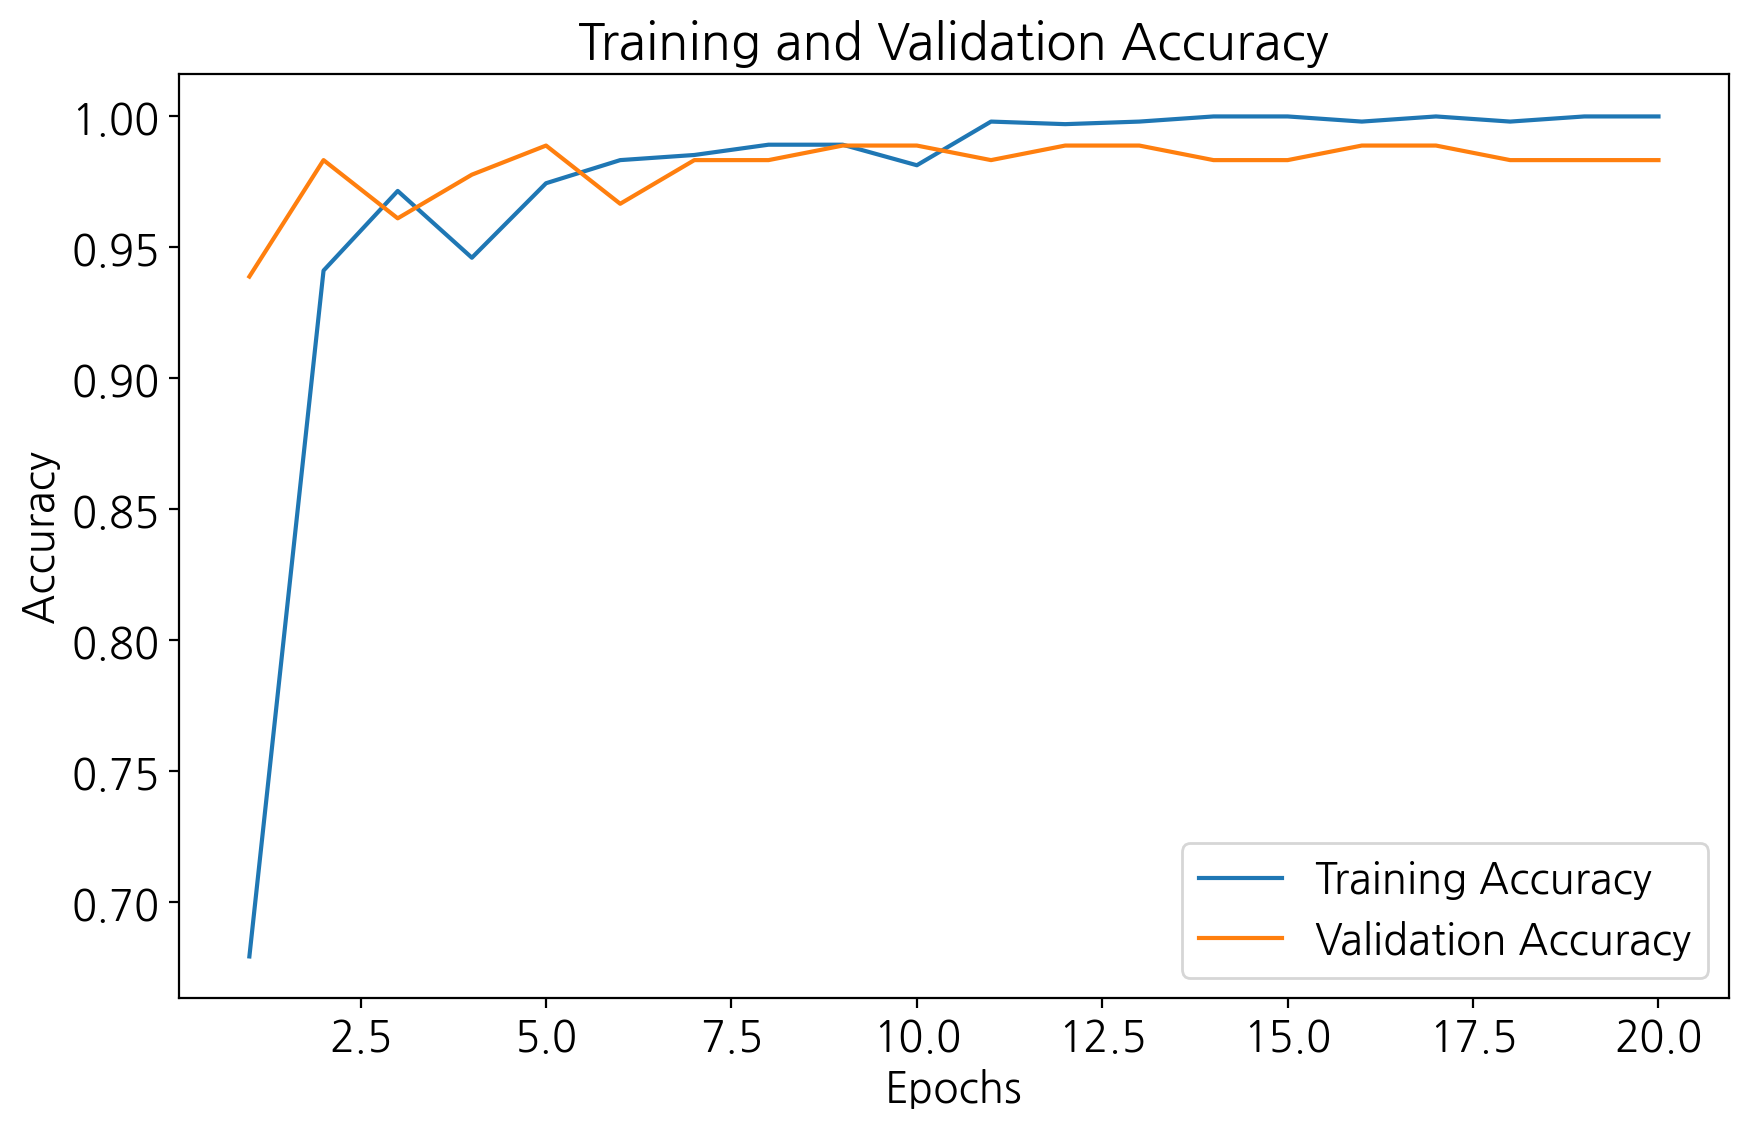

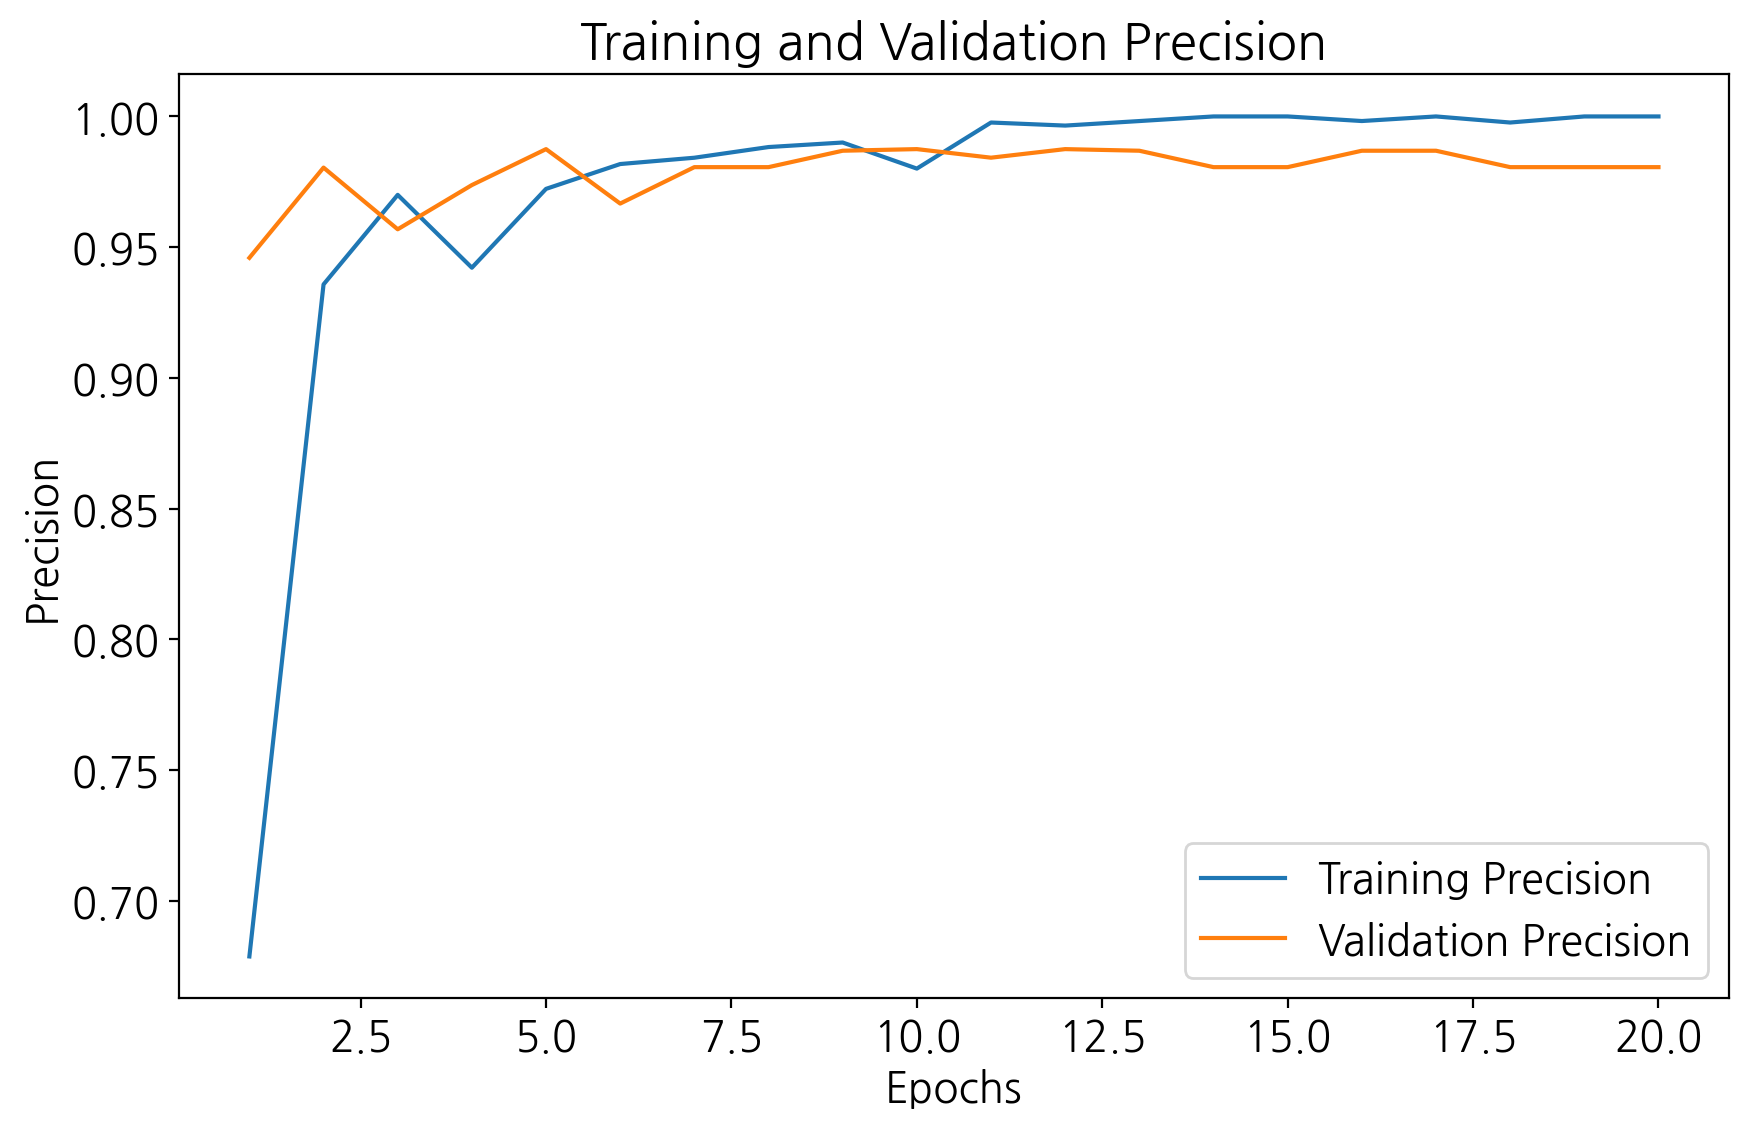

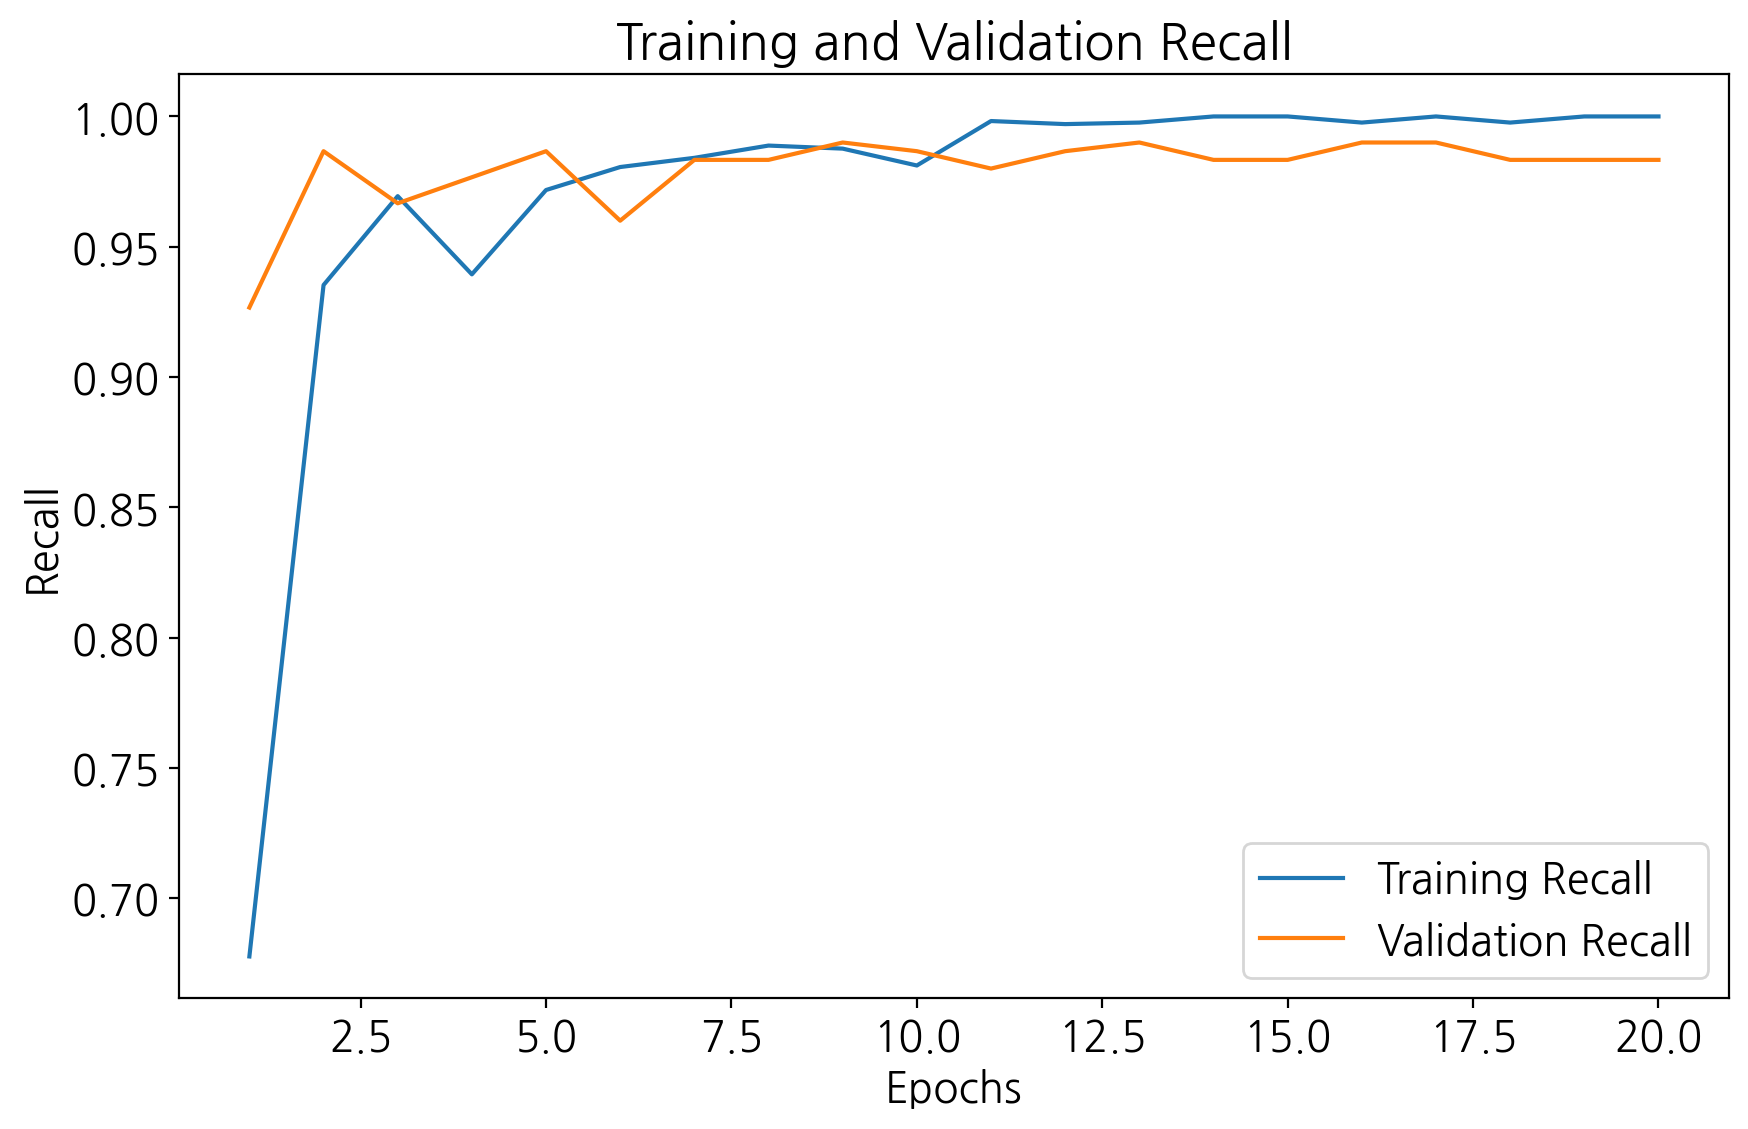

In [43]:
# Train, validation 성능 변화 과정 시각화
plot_training_metrics(history_list[2], epochs)

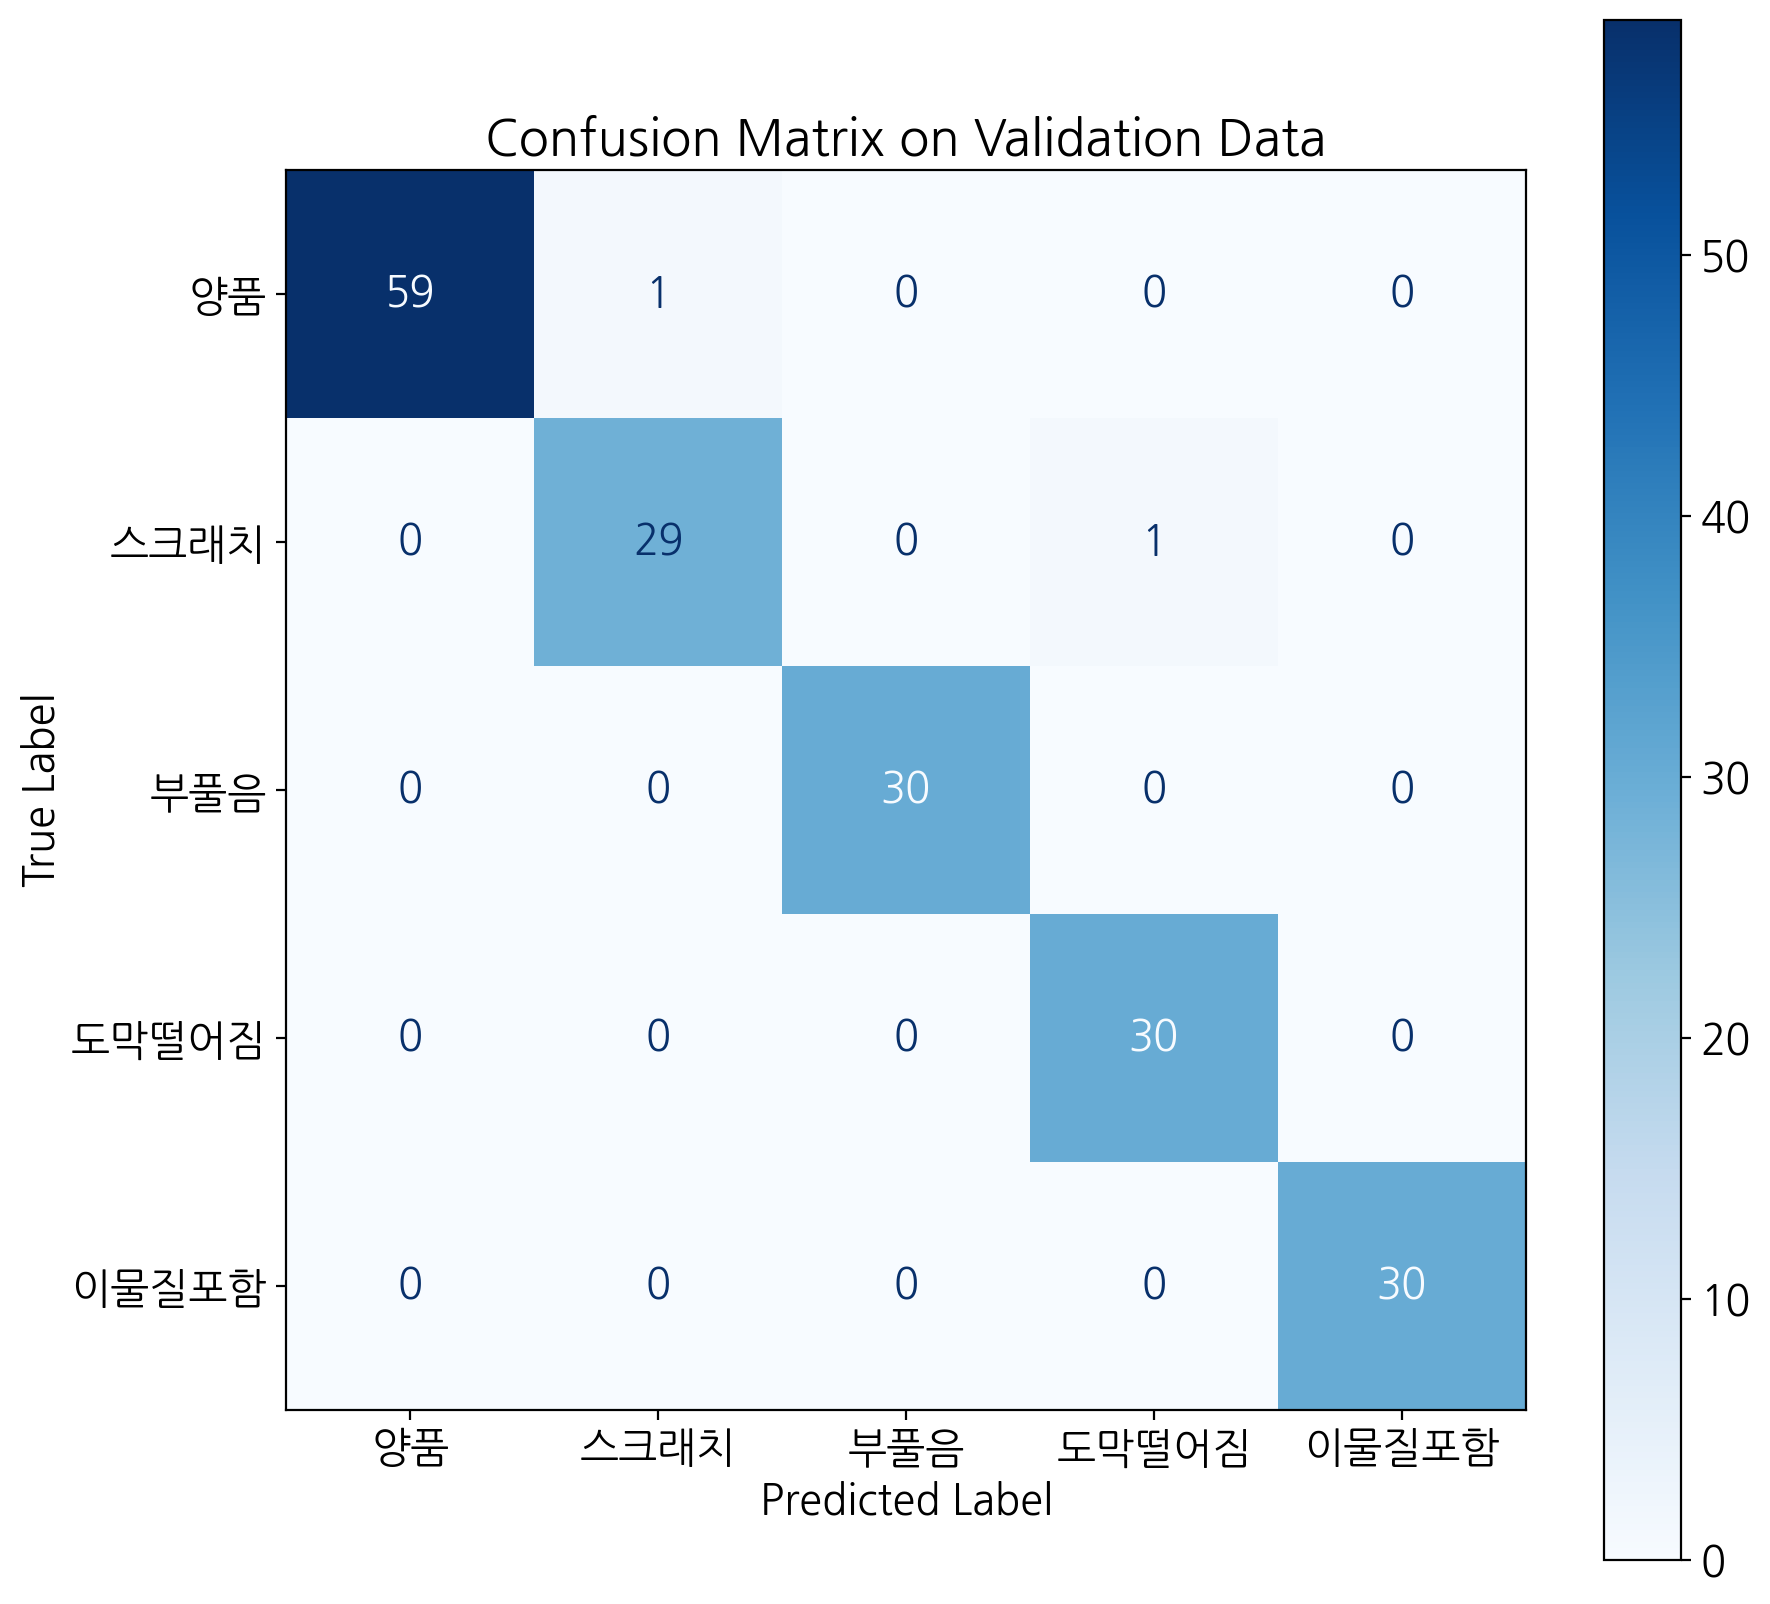

-------------------- Classification Report --------------------
              precision    recall  f1-score   support

          양품       1.00      0.98      0.99        60
        스크래치       0.97      0.97      0.97        30
         부풀음       1.00      1.00      1.00        30
       도막떨어짐       0.97      1.00      0.98        30
       이물질포함       1.00      1.00      1.00        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

---------------------------------------------------------------


In [44]:
# Validation 데이터셋에 대한 Confusion Matrix 및 Classification Report
evaluate_and_plot(
    model=models_list[2],
    loader_valid=loader_valid,
    device=device,
    class_names=class_names_list
)

## 제출 점수


## 예측 및 결과 제출

In [46]:
SUBMIT_DIR = ROOT / "제출용 데이터"

filenames, labels = [], []
X_sub = []
for p in tqdm(SUBMIT_DIR.rglob("*")):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
#         im = Image.open(p).convert("L").resize(IMG_SIZE)
        im = Image.open(p).resize(IMG_SIZE)
        x = np.array(im)
        X_sub.append(x)
#         y_pred = clf.predict(x)
#         label_ko = le.inverse_transform(y_pred)[0]  # 한글 라벨 복원
        filenames.append(p.name)  # 인덱스는 파일명(문자열)
#         labels.append(label_ko)

0it [00:00, ?it/s]

In [47]:
len(filenames)

1000

In [48]:
# Dataset 객체 생성
dataset_test = ImageDataset(X=X_sub, transform=transform_test)

# DataLoader 객체 생성
loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

### 추론

In [49]:
def predict(model, loader_test):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images in tqdm(loader_test):
            images = images.to(device)

            outputs = model(images)
            
            preds = F.softmax(outputs.cpu(), dim=1).numpy()

            preds_list.extend(preds)

    return preds_list

In [50]:
preds_list_1 = predict(model=models_list[0], loader_test=loader_test)
preds_list_2 = predict(model=models_list[1], loader_test=loader_test)
preds_list_3 = predict(model=models_list[2], loader_test=loader_test)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

### 앙상블 예측

In [51]:
def ensemble_predictions_soft_voting(preds_probs_lists):
    """
    여러 모델의 예측을 앙상블합니다 (소프트 보팅).

    Args:
        preds_probs_lists (list of list): 각 모델의 예측 확률 리스트를 담은 리스트.
        
    Returns:
        list: 앙상블된 최종 예측 클래스 인덱스 리스트.
    """
    if not preds_probs_lists:
        return []

    # 모든 모델의 예측 확률 배열을 하나의 numpy 배열로 합치기
    # 예를 들어, [[모델1 예측], [모델2 예측], ...] 형태
    # 이것을 (모델 수, 샘플 수, 클래스 수) 형태의 3D 배열로 변환
    all_preds = np.array(preds_probs_lists)
    
    # 각 샘플에 대해 모든 모델의 확률을 합산
    # (샘플 수, 클래스 수) 형태의 2D 배열이 됨
    summed_probs = np.sum(all_preds, axis=0)
    
    # 합산된 확률에서 가장 높은 값을 가진 클래스 인덱스를 최종 예측으로 선택
    ensemble_preds = np.argmax(summed_probs, axis=1).tolist()
    
    return ensemble_preds

In [52]:
# 앙상블 예측을 수행합니다.
preds_probs_lists = [preds_list_1, preds_list_2, preds_list_3]
ensemble_preds = ensemble_predictions_soft_voting(preds_probs_lists)

In [53]:
label_dict = {'양품': 0, '스크래치': 1, '부풀음': 2, '도막떨어짐':3, '이물질포함':4}
reverse_label_map = {v: k for k, v in label_dict.items()}
preds_labels = [reverse_label_map[pred] for pred in ensemble_preds]
# preds_labels

In [54]:
# 제출을 위한 데이터프레임 만들기
df_submit = pd.DataFrame({"label": preds_labels}, index=filenames)
df_submit = df_submit.sort_index() 
df_submit.to_csv("./submission.csv", encoding="utf-8")  # 현재 작업 디렉토리에 저장

df_submit.head()

label
00001.jpg  도막떨어짐
00002.jpg  도막떨어짐
00003.jpg   스크래치
00004.jpg   스크래치
00005.jpg     양품

### 예측값 분포 확인

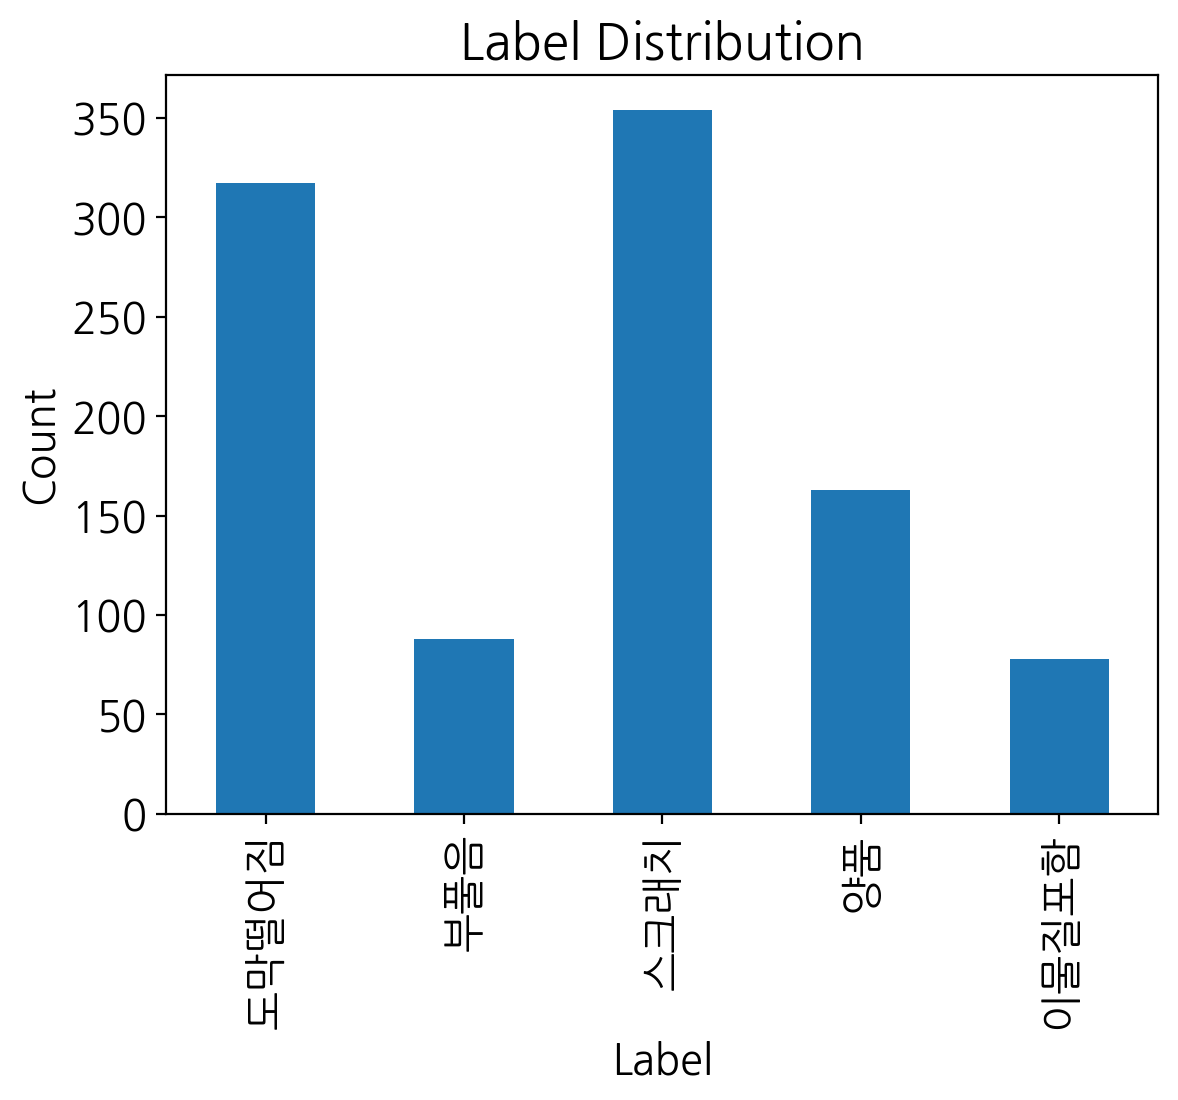

In [55]:
df_submit['label'].value_counts().sort_index().plot(kind='bar')

# 히스토그램 제목과 축 레이블 설정
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()

## Public Score 기록

1. Public Score : 0.97485
- Efficientnet-b1, 2, 3 : Soft-voting
- RGB, (224, 224)
- Data Augmentation : transforms, Train - CenterCrop(180), RandomHorizontalFlip(0.5), RandomVerticalFlip(0.2), RandomRotation(20) / Test - CenterCrop(180)
- Fine-tuning : CNN layer, classifier
- Validation_ratio=0.15, BS=16, Epochs=20, Val-F1(best model)
- AdamW : lr=0.0006, weight_decay=0.001
- LR_Scheduler : get_cosine_schedule_with_warmup